## Importing required Python Packages and Libraries

In [248]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import datetime as dt
from datetime import timedelta
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,r2_score
import statsmodels.api as sm
from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
std=StandardScaler()

In [249]:
covid=pd.read_csv("covid_19_data.csv")
covid.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.000000,0.000000,0.000000
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.000000,0.000000,0.000000
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.000000,0.000000,0.000000
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.000000,0.000000,0.000000
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.000000,0.000000,0.000000


In [250]:
print("Size/Shape of the dataset: ",covid.shape)
print("Checking for null values:\n",covid.isnull().sum())
print("Checking Data-type of each column:\n",covid.dtypes)

Size/Shape of the dataset:  (98252, 8)
Checking for null values:
 SNo                    0
ObservationDate        0
Province/State     31153
Country/Region         0
Last Update            0
Confirmed              0
Deaths                 0
Recovered              0
dtype: int64
Checking Data-type of each column:
 SNo                  int64
ObservationDate     object
Province/State      object
Country/Region      object
Last Update         object
Confirmed          float64
Deaths             float64
Recovered          float64
dtype: object


In [251]:
# Dropping column as SNo is of no use, and "Province/State" contains too many missing values
covid.drop(["SNo"],1,inplace=True)

In [252]:
# Converting "Observation Date" into Datetime format
covid["ObservationDate"]=pd.to_datetime(covid["ObservationDate"])

In [253]:
grouped_country=covid.groupby(["Country/Region","ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})

In [254]:
grouped_country["Active Cases"]=grouped_country["Confirmed"]-grouped_country["Recovered"]-grouped_country["Deaths"]
grouped_country["log_confirmed"]=np.log(grouped_country["Confirmed"])
grouped_country["log_active"]=np.log(grouped_country["Active Cases"])

## Datewise analysis 

In [255]:
# Grouping different types of cases as per the date
datewise=covid.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
datewise["Days Since"]=datewise.index-datewise.index.min()

In [256]:
print("Basic Information")
print("Totol number of countries with Disease Spread: ",len(covid["Country/Region"].unique()))
print("Total number of Confirmed Cases around the World: ",datewise["Confirmed"].iloc[-1])
print("Total number of Recovered Cases around the World: ",datewise["Recovered"].iloc[-1])
print("Total number of Deaths Cases around the World: ",datewise["Deaths"].iloc[-1])
print("Total number of Active Cases around the World: ",(datewise["Confirmed"].iloc[-1]-datewise["Recovered"].iloc[-1]-datewise["Deaths"].iloc[-1]))
print("Total number of Closed Cases around the World: ",datewise["Recovered"].iloc[-1]+datewise["Deaths"].iloc[-1])
print("Approximate number of Confirmed Cases per Day around the World: ",np.round(datewise["Confirmed"].iloc[-1]/datewise.shape[0]))
print("Approximate number of Recovered Cases per Day around the World: ",np.round(datewise["Recovered"].iloc[-1]/datewise.shape[0]))
print("Approximate number of Death Cases per Day around the World: ",np.round(datewise["Deaths"].iloc[-1]/datewise.shape[0]))
print("Approximate number of Confirmed Cases per hour around the World: ",np.round(datewise["Confirmed"].iloc[-1]/((datewise.shape[0])*24)))
print("Approximate number of Recovered Cases per hour around the World: ",np.round(datewise["Recovered"].iloc[-1]/((datewise.shape[0])*24)))
print("Approximate number of Death Cases per hour around the World: ",np.round(datewise["Deaths"].iloc[-1]/((datewise.shape[0])*24)))
print("Number of Confirmed Cases in last 24 hours: ",datewise["Confirmed"].iloc[-1]-datewise["Confirmed"].iloc[-2])
print("Number of Recovered Cases in last 24 hours: ",datewise["Recovered"].iloc[-1]-datewise["Recovered"].iloc[-2])
print("Number of Death Cases in last 24 hours: ",datewise["Deaths"].iloc[-1]-datewise["Deaths"].iloc[-2])

Basic Information
Totol number of countries with Disease Spread:  223
Total number of Confirmed Cases around the World:  24996456.0
Total number of Recovered Cases around the World:  16409757.0
Total number of Deaths Cases around the World:  842499.0
Total number of Active Cases around the World:  7744200.0
Total number of Closed Cases around the World:  17252256.0
Approximate number of Confirmed Cases per Day around the World:  113106.0
Approximate number of Recovered Cases per Day around the World:  74252.0
Approximate number of Death Cases per Day around the World:  3812.0
Approximate number of Confirmed Cases per hour around the World:  4713.0
Approximate number of Recovered Cases per hour around the World:  3094.0
Approximate number of Death Cases per hour around the World:  159.0
Number of Confirmed Cases in last 24 hours:  262008.0
Number of Recovered Cases in last 24 hours:  211592.0
Number of Death Cases in last 24 hours:  5375.0


In [257]:
fig=px.bar(x=datewise.index,y=datewise["Confirmed"]-datewise["Recovered"]-datewise["Deaths"])
fig.update_layout(title="Distribution of Number of Active Cases",
                  xaxis_title="Date",yaxis_title="Number of Cases",)
fig.show()

#### Active Cases = Number of Confirmed Cases - Number of Recovered Cases - Number of Death Cases
#### Increase in number of Active Cases is probably an indication of Recovered case or Death case number is dropping in comparison to number of Confirmed Cases drastically. Will look for the conclusive evidence for the same in the notebook ahead.

In [258]:
fig=px.bar(x=datewise.index,y=datewise["Recovered"]+datewise["Deaths"])
fig.update_layout(title="Distribution of Number of Closed Cases",
                  xaxis_title="Date",yaxis_title="Number of Cases")
fig.show()

#### Closed Cases = Number of Recovered Cases + Number of Death Cases 
#### Increase in number of Closed classes imply either more patients are getting recovered from the disease or more pepole are dying because of COVID-19

In [259]:
datewise["WeekOfYear"]=datewise.index.weekofyear

week_num=[]
weekwise_confirmed=[]
weekwise_recovered=[]
weekwise_deaths=[]
w=1
for i in list(datewise["WeekOfYear"].unique()):
    weekwise_confirmed.append(datewise[datewise["WeekOfYear"]==i]["Confirmed"].iloc[-1])
    weekwise_recovered.append(datewise[datewise["WeekOfYear"]==i]["Recovered"].iloc[-1])
    weekwise_deaths.append(datewise[datewise["WeekOfYear"]==i]["Deaths"].iloc[-1])
    week_num.append(w)
    w=w+1

fig=go.Figure()
fig.add_trace(go.Scatter(x=week_num, y=weekwise_confirmed,
                    mode='lines+markers',
                    name='Weekly Growth of Confirmed Cases'))
fig.add_trace(go.Scatter(x=week_num, y=weekwise_recovered,
                    mode='lines+markers',
                    name='Weekly Growth of Recovered Cases'))
fig.add_trace(go.Scatter(x=week_num, y=weekwise_deaths,
                    mode='lines+markers',
                    name='Weekly Growth of Death Cases'))
fig.update_layout(title="Weekly Growth of different types of Cases in India",
                 xaxis_title="Week Number",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

Text(0.5, 1.0, 'Weekly increase in Number of Death Cases')

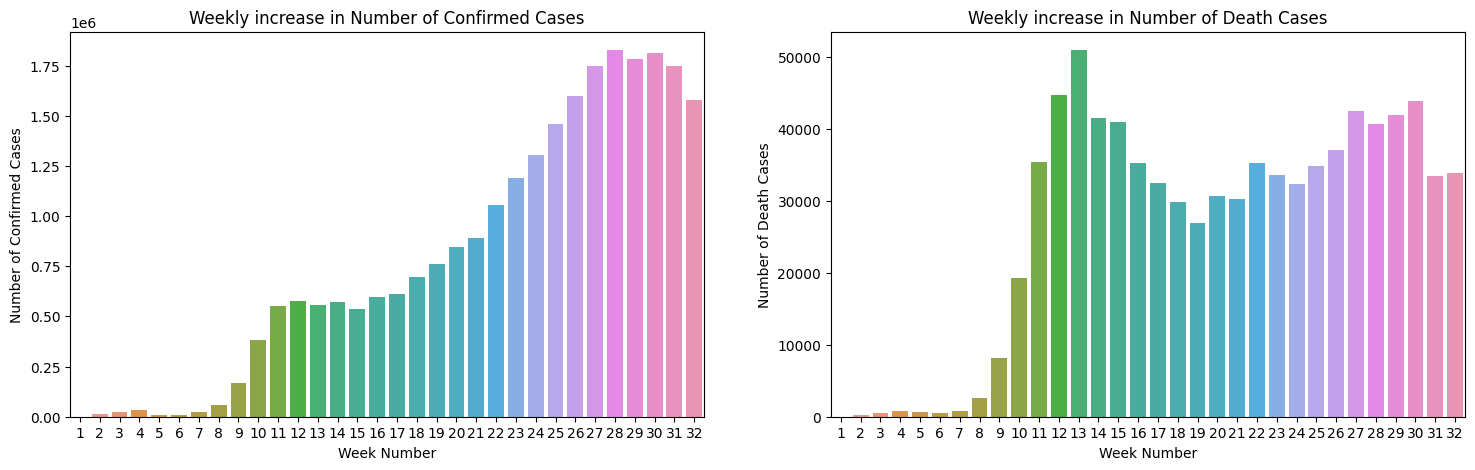

In [260]:
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(18,5))
sns.barplot(x=week_num,y=pd.Series(weekwise_confirmed).diff().fillna(0),ax=ax1)
sns.barplot(x=week_num,y=pd.Series(weekwise_deaths).diff().fillna(0),ax=ax2)
ax1.set_xlabel("Week Number")
ax2.set_xlabel("Week Number")
ax1.set_ylabel("Number of Confirmed Cases")
ax2.set_ylabel("Number of Death Cases")
ax1.set_title("Weekly increase in Number of Confirmed Cases")
ax2.set_title("Weekly increase in Number of Death Cases")

##### 32nd week id currently going on.

The death toll was low in 14th week, as it was expected to rise looking at the trend of infection of death trend of previous few weeks.

Number of Death cases were consistently dropping since 14th week, upto 19th week. After which it's again showing a spike for two consecutive weeks.

We are somehow able to reduce the Death Numbers or maybe able to control it somehow, but new infections are increasing with considerable speed recording 800k+ cases in 21st week which is a staggering number.

The number infections are increasing every week, recording 1.2M+ Confirmed Cases in 24th week. 25th Week has recorded another peak in number of Confirmed Cases (1.5M+)

The infection rate is increasing with every passing week.

#### Growth rate of Confirmed, Recovered and Death Cases 

In [261]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Confirmed"],
                    mode='lines+markers',
                    name='Confirmed Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Recovered"],
                    mode='lines+markers',
                    name='Recovered Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Deaths"],
                    mode='lines+markers',
                    name='Death Cases'))
fig.update_layout(title="Growth of different types of cases",
                 xaxis_title="Date",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

#### Moratality and Recovery Rate analysis around the World

In [262]:
#Calculating the Mortality Rate and Recovery Rate
datewise["Mortality Rate"]=(datewise["Deaths"]/datewise["Confirmed"])*100
datewise["Recovery Rate"]=(datewise["Recovered"]/datewise["Confirmed"])*100
datewise["Active Cases"]=datewise["Confirmed"]-datewise["Recovered"]-datewise["Deaths"]
datewise["Closed Cases"]=datewise["Recovered"]+datewise["Deaths"]

print("Average Mortality Rate",datewise["Mortality Rate"].mean())
print("Median Mortality Rate",datewise["Mortality Rate"].median())
print("Average Recovery Rate",datewise["Recovery Rate"].mean())
print("Median Recovery Rate",datewise["Recovery Rate"].median())

#Plotting Mortality and Recovery Rate 
fig = make_subplots(rows=2, cols=1,
                   subplot_titles=("Recovery Rate", "Mortatlity Rate"))
fig.add_trace(
    go.Scatter(x=datewise.index, y=(datewise["Recovered"]/datewise["Confirmed"])*100,name="Recovery Rate"),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=datewise.index, y=(datewise["Deaths"]/datewise["Confirmed"])*100,name="Mortality Rate"),
    row=2, col=1
)
fig.update_layout(height=1000,legend=dict(x=-0.1,y=1.2,traceorder="normal"))
fig.update_xaxes(title_text="Date", row=1, col=1)
fig.update_yaxes(title_text="Recovery Rate", row=1, col=1)
fig.update_xaxes(title_text="Date", row=1, col=2)
fig.update_yaxes(title_text="Mortality Rate", row=1, col=2)
fig.show()

Average Mortality Rate 4.634104124836859
Median Mortality Rate 4.4083056727246195
Average Recovery Rate 39.16083883932324
Median Recovery Rate 42.09012917192399


#### Mortality rate = (Number of Death Cases / Number of Confirmed Cases) x 100
#### Recovery Rate= (Number of Recoverd Cases / Number of Confirmed Cases) x 100
#### Mortality rate is showing a considerable for a pretty long time, which is positive sign
#### Recovery Rate has started to pick up again which is a good sign, another supportive reason to why number of Closed Cases are increasing

In [263]:
print("Average increase in number of Confirmed Cases every day: ",np.round(datewise["Confirmed"].diff().fillna(0).mean()))
print("Average increase in number of Recovered Cases every day: ",np.round(datewise["Recovered"].diff().fillna(0).mean()))
print("Average increase in number of Deaths Cases every day: ",np.round(datewise["Deaths"].diff().fillna(0).mean()))

fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Confirmed"].diff().fillna(0),mode='lines+markers',
                    name='Confirmed Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Recovered"].diff().fillna(0),mode='lines+markers',
                    name='Recovered Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Deaths"].diff().fillna(0),mode='lines+markers',
                    name='Death Cases'))
fig.update_layout(title="Daily increase in different types of Cases",
                 xaxis_title="Date",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

Average increase in number of Confirmed Cases every day:  113104.0
Average increase in number of Recovered Cases every day:  74252.0
Average increase in number of Deaths Cases every day:  3812.0


In [264]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Confirmed"].diff().rolling(window=7).mean(),mode='lines+markers',
                    name='Confirmed Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Recovered"].diff().rolling(window=7).mean(),mode='lines+markers',
                    name='Recovered Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Deaths"].diff().rolling(window=7).mean(),mode='lines+markers',
                    name='Death Cases'))
fig.update_layout(title="7 Days Rolling Mean of Daily Increase of Confirmed, Recovered and Death Cases",
                 xaxis_title="Date",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

### Growth Factor
Growth factor is the factor by which a quantity multiplies itself over time. The formula used is:

**Formula: Every day's new (Confirmed,Recovered,Deaths) / new (Confirmed,Recovered,Deaths) on the previous day.**

A growth factor **above 1 indicates an increase correspoding cases**.

A growth factor **above 1 but trending downward** is a positive sign, whereas a **growth factor constantly above 1 is the sign of exponential growth**.

A growth factor **constant at 1 indicates there is no change in any kind of cases**.

In [265]:
print("Average growth factor of number of Confirmed Cases: ",(datewise["Confirmed"]/datewise["Confirmed"].shift()).mean())
print("Median growth factor of number of Confirmed Cases: ",(datewise["Confirmed"]/datewise["Confirmed"].shift()).median())
print("Average growth factor of number of Recovered Cases: ",(datewise["Recovered"]/datewise["Recovered"].shift()).mean())
print("Median growth factor of number of Recovered Cases: ",(datewise["Recovered"]/datewise["Recovered"].shift()).median())
print("Average growth factor of number of Death Cases: ",(datewise["Deaths"]/datewise["Deaths"].shift()).mean())
print("Median growth factor of number of Death Cases: ",(datewise["Deaths"]/datewise["Deaths"].shift()).median())

fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Confirmed"]/datewise["Confirmed"].shift(),
                    mode='lines',
                    name='Growth Factor of Confirmed Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Recovered"]/datewise["Recovered"].shift(),
                    mode='lines',
                    name='Growth Factor of Recovered Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Deaths"]/datewise["Deaths"].shift(),
                    mode='lines',
                    name='Growth Factor of Death Cases'))
fig.update_layout(title="Datewise Growth Factor of different types of cases",
                 xaxis_title="Date",yaxis_title="Growth Factor",
                 legend=dict(x=0,y=-0.4,traceorder="normal"))
fig.show()

Average growth factor of number of Confirmed Cases:  1.0534037322997345
Median growth factor of number of Confirmed Cases:  1.0202013845748947
Average growth factor of number of Recovered Cases:  1.0659417596633376
Median growth factor of number of Recovered Cases:  1.0305531800502579
Average growth factor of number of Death Cases:  1.0534793524039714
Median growth factor of number of Death Cases:  1.0153996847560398


#### Growth Factor for Active and Closed Cases
Growth factor is the factor by which a quantity multiplies itself over time. The formula used is:

**Formula: Every day's new (Active and Closed Cases) / new (Active and Closed Cases) on the previous day.**

A growth factor **above 1 indicates an increase correspoding cases.**

A growth factor **above 1 but trending downward is a positive sign.**

A growth factor **constant at 1 indicates there is no change in any kind of cases.**

A growth factor **below 1 indicates real positive sign implying more patients are getting recovered or dying as compared to the Confirmed Cases.**

In [266]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, 
                         y=(datewise["Confirmed"]-datewise["Recovered"]-datewise["Deaths"])/(datewise["Confirmed"]-datewise["Recovered"]-datewise["Deaths"]).shift(),
                    mode='lines',
                    name='Growth Factor of Active Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=(datewise["Recovered"]+datewise["Deaths"])/(datewise["Recovered"]+datewise["Deaths"]).shift(),
                    mode='lines',
                    name='Growth Factor of Closed Cases'))
fig.update_layout(title="Datewise Growth Factor of Active and Closed Cases",
                 xaxis_title="Date",yaxis_title="Growth Factor",
                 legend=dict(x=0,y=-0.4,traceorder="normal"))
fig.show()

#### Growth Factor constantly above 1 is an clear indication of Exponential increase in all form of cases.

### Rate of Doubling for Confirmed Cases around the World

In [267]:
c=560
double_days=[]
C=[]
while(1):
    double_days.append(datewise[datewise["Confirmed"]<=c].iloc[[-1]]["Days Since"][0])
    C.append(c)
    c=c*2
    if(c<datewise["Confirmed"].max()):
        continue
    else:
        break

In [268]:
doubling_rate=pd.DataFrame(list(zip(C,double_days)),columns=["No. of cases","Days since first Case"])
doubling_rate["Number of days for doubling"]=doubling_rate["Days since first Case"].diff().fillna(doubling_rate["Days since first Case"])
doubling_rate

,No. of cases,Days since first Case,Number of days for doubling
0,560,0 days,0 days
1,1120,2 days,2 days
2,2240,4 days,2 days
3,4480,5 days,1 days
4,8960,8 days,3 days
5,17920,11 days,3 days
6,35840,16 days,5 days
7,71680,25 days,9 days
8,143360,50 days,25 days
9,286720,58 days,8 days


#### Doubling Rate is fluctuating very much, which ideally supposed to increase if we are successfully faltening the curve.

### Number of days requried for increase in Confirmed Cases by 300K

In [269]:
c1=100000
days_300k=[]
C1=[]
while(1):
    days_300k.append(datewise[datewise["Confirmed"]<=c1].iloc[[-1]]["Days Since"][0])
    C1.append(c1)
    c1=c1+300000
    if(c1<datewise["Confirmed"].max()):
        continue
    else:
        break

In [270]:
rate_300k=pd.DataFrame(list(zip(C1,days_300k)),columns=["No. of Cases","Days Since first Case"])
rate_300k["Days requried for rise of 300K"]=rate_300k["Days Since first Case"].diff().fillna(rate_300k["Days Since first Case"].iloc[[0]][0])

fig=go.Figure()
fig.add_trace(go.Scatter(x=rate_300k["No. of Cases"], y=rate_300k["Days requried for rise of 300K"].dt.days,
                    mode='lines+markers',
                    name='Weekly Growth of Confirmed Cases'))
fig.update_layout(title="Number of Days required for increase in number of cases by 300K",
                 xaxis_title="Number of Cases",yaxis_title="Number of Days")
fig.show()

It's hardly taking a day or two for rise in cases by 300k, which is pretty much a clear indication that we are still not able to "Flatten the curve"

## Countrywise Analysis

In [271]:
#Calculating countrywise Moratality and Recovery Rate
countrywise=covid[covid["ObservationDate"]==covid["ObservationDate"].max()].groupby(["Country/Region"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'}).sort_values(["Confirmed"],ascending=False)
countrywise["Mortality"]=(countrywise["Deaths"]/countrywise["Confirmed"])*100
countrywise["Recovery"]=(countrywise["Recovered"]/countrywise["Confirmed"])*100

In [272]:
country_last_24_confirmed=[]
country_last_24_recovered=[]
country_last_24_deaths=[]
for country in countrywise.index:
    country_last_24_confirmed.append((grouped_country.loc[country].iloc[-1]-grouped_country.loc[country].iloc[-2])["Confirmed"])
    country_last_24_recovered.append((grouped_country.loc[country].iloc[-1]-grouped_country.loc[country].iloc[-2])["Recovered"])
    country_last_24_deaths.append((grouped_country.loc[country].iloc[-1]-grouped_country.loc[country].iloc[-2])["Deaths"])

In [273]:
Last_24_Hours_country=pd.DataFrame(list(zip(countrywise.index,country_last_24_confirmed,country_last_24_recovered,country_last_24_deaths)),
                                   columns=["Country Name","Last 24 Hours Confirmed","Last 24 Hours Recovered","Last 24 Hours Deaths"])

Text(0.5, 1.0, 'Top 15 Countries with Highest Number of Death Cases in Last 24 Hours')

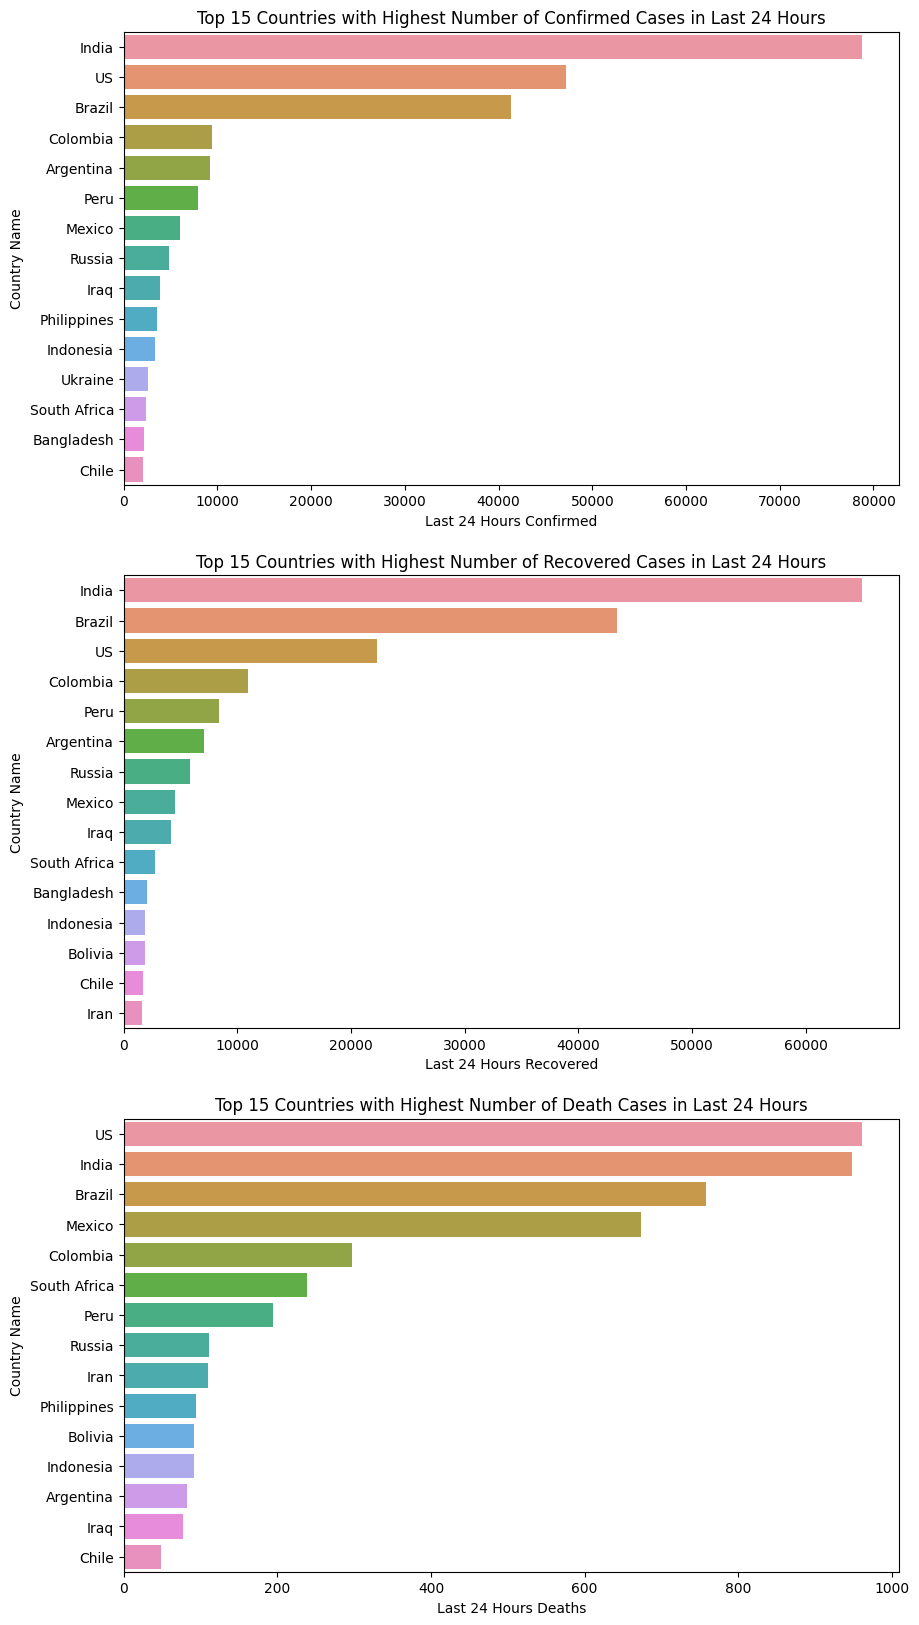

In [274]:
Top_15_Confirmed_24hr=Last_24_Hours_country.sort_values(["Last 24 Hours Confirmed"],ascending=False).head(15)
Top_15_Recoverd_24hr=Last_24_Hours_country.sort_values(["Last 24 Hours Recovered"],ascending=False).head(15)
Top_15_Deaths_24hr=Last_24_Hours_country.sort_values(["Last 24 Hours Deaths"],ascending=False).head(15)


fig, (ax1, ax2, ax3) = plt.subplots(3, 1,figsize=(10,20))
sns.barplot(x=Top_15_Confirmed_24hr["Last 24 Hours Confirmed"],y=Top_15_Confirmed_24hr["Country Name"],ax=ax1)
ax1.set_title("Top 15 Countries with Highest Number of Confirmed Cases in Last 24 Hours")
sns.barplot(x=Top_15_Recoverd_24hr["Last 24 Hours Recovered"],y=Top_15_Recoverd_24hr["Country Name"],ax=ax2)
ax2.set_title("Top 15 Countries with Highest Number of Recovered Cases in Last 24 Hours")
sns.barplot(x=Top_15_Deaths_24hr["Last 24 Hours Deaths"],y=Top_15_Deaths_24hr["Country Name"],ax=ax3)
ax3.set_title("Top 15 Countries with Highest Number of Death Cases in Last 24 Hours")

In [275]:
Last_24_Hours_country["Proportion of Confirmed"]=(Last_24_Hours_country["Last 24 Hours Confirmed"]/(datewise["Confirmed"].iloc[-1]-datewise["Confirmed"].iloc[-2]))*100
Last_24_Hours_country["Proportion of Recovered"]=(Last_24_Hours_country["Last 24 Hours Recovered"]/(datewise["Recovered"].iloc[-1]-datewise["Recovered"].iloc[-2]))*100
Last_24_Hours_country["Proportion of Deaths"]=(Last_24_Hours_country["Last 24 Hours Deaths"]/(datewise["Deaths"].iloc[-1]-datewise["Deaths"].iloc[-2]))*100

### Proportion of Countries in Confirmed, Recovered and Death Cases 

In [276]:
Last_24_Hours_country[["Country Name","Proportion of Confirmed","Proportion of Recovered","Proportion of Deaths"]].sort_values(["Proportion of Confirmed"],ascending=False).style.background_gradient(cmap="Reds")

,Country Name,Proportion of Confirmed,Proportion of Recovered,Proportion of Deaths
2,India,30.060533,30.688778,17.637209
0,US,17.996779,10.514103,17.879070
1,Brazil,15.781961,20.512118,14.102326
6,Colombia,3.584623,5.176944,5.525581
10,Argentina,3.522793,3.334247,1.525581
4,Peru,3.039602,3.948637,3.609302
7,Mexico,2.280083,2.132878,12.520930
3,Russia,1.848417,2.772789,2.065116
20,Iraq,1.463314,1.959431,1.432558
21,Philippines,1.369042,0.296325,1.748837


Text(0.5, 1.0, 'Top 15 countries as per Number of Death Cases')

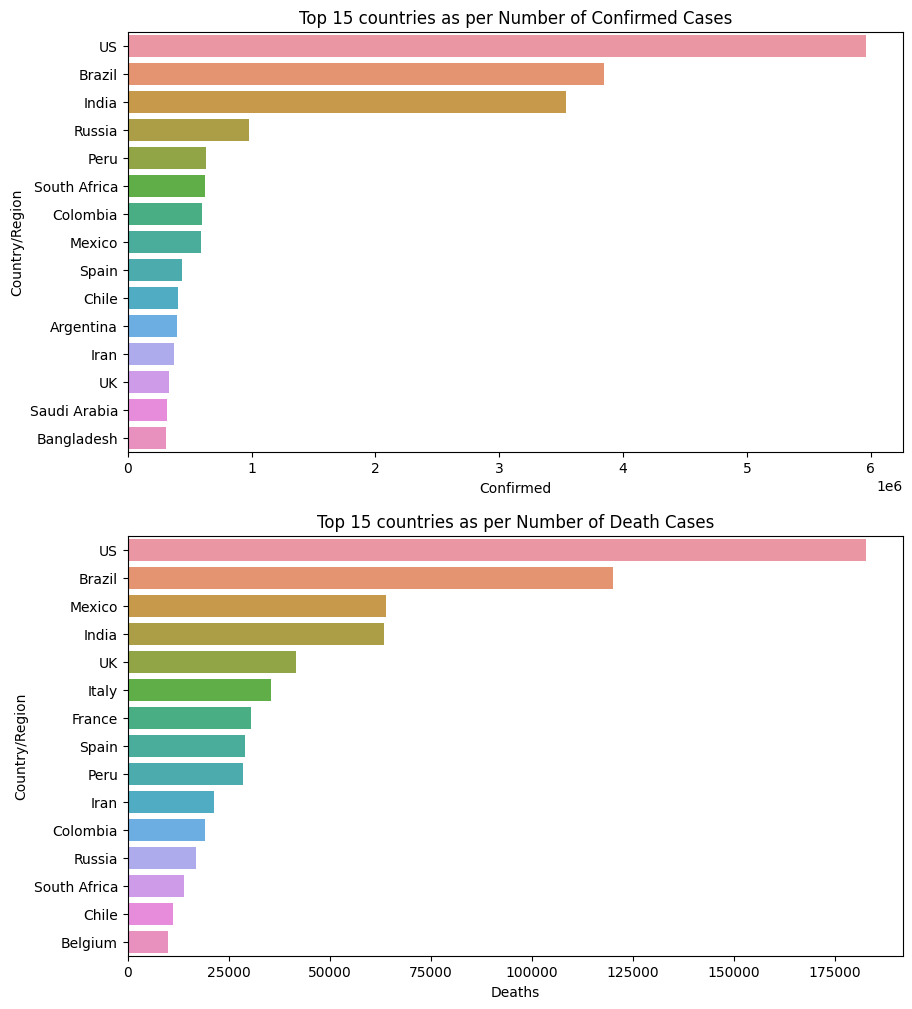

In [277]:
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(10,12))
top_15_confirmed=countrywise.sort_values(["Confirmed"],ascending=False).head(15)
top_15_deaths=countrywise.sort_values(["Deaths"],ascending=False).head(15)
sns.barplot(x=top_15_confirmed["Confirmed"],y=top_15_confirmed.index,ax=ax1)
ax1.set_title("Top 15 countries as per Number of Confirmed Cases")
sns.barplot(x=top_15_deaths["Deaths"],y=top_15_deaths.index,ax=ax2)
ax2.set_title("Top 15 countries as per Number of Death Cases")

#### Top 25 Countries as per Mortatlity Rate and Recovery Rate with more than 500 Confirmed Cases

Text(0.5, 0, 'Recovery (in Percentage)')

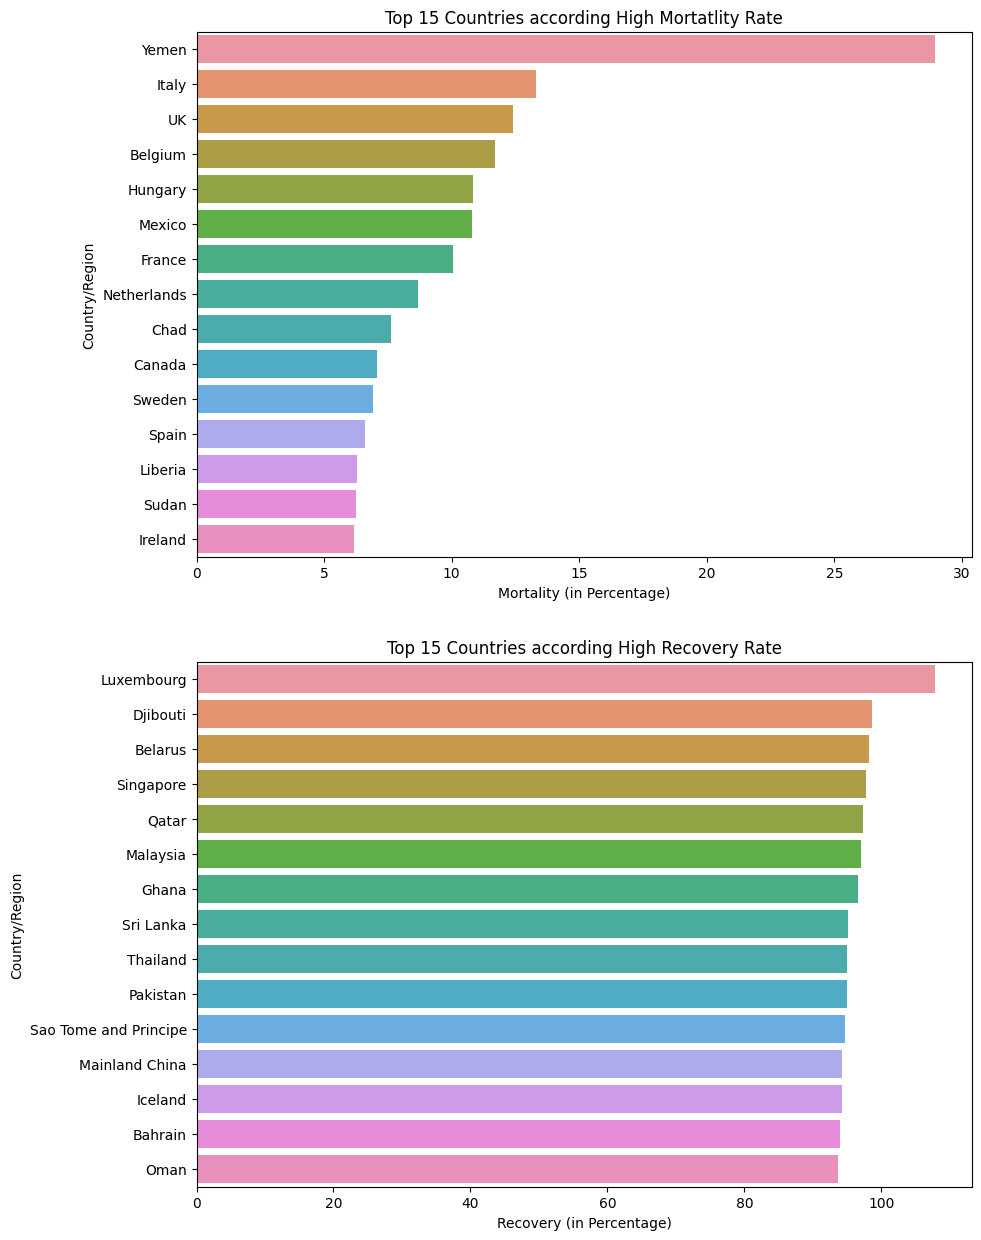

In [278]:
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(10,15))
countrywise_plot_mortal=countrywise[countrywise["Confirmed"]>500].sort_values(["Mortality"],ascending=False).head(15)
sns.barplot(x=countrywise_plot_mortal["Mortality"],y=countrywise_plot_mortal.index,ax=ax1)
ax1.set_title("Top 15 Countries according High Mortatlity Rate")
ax1.set_xlabel("Mortality (in Percentage)")
countrywise_plot_recover=countrywise[countrywise["Confirmed"]>500].sort_values(["Recovery"],ascending=False).head(15)
sns.barplot(x=countrywise_plot_recover["Recovery"],y=countrywise_plot_recover.index, ax=ax2)
ax2.set_title("Top 15 Countries according High Recovery Rate")
ax2.set_xlabel("Recovery (in Percentage)")

Text(0.5, 0, 'Recovery (in Percentage)')

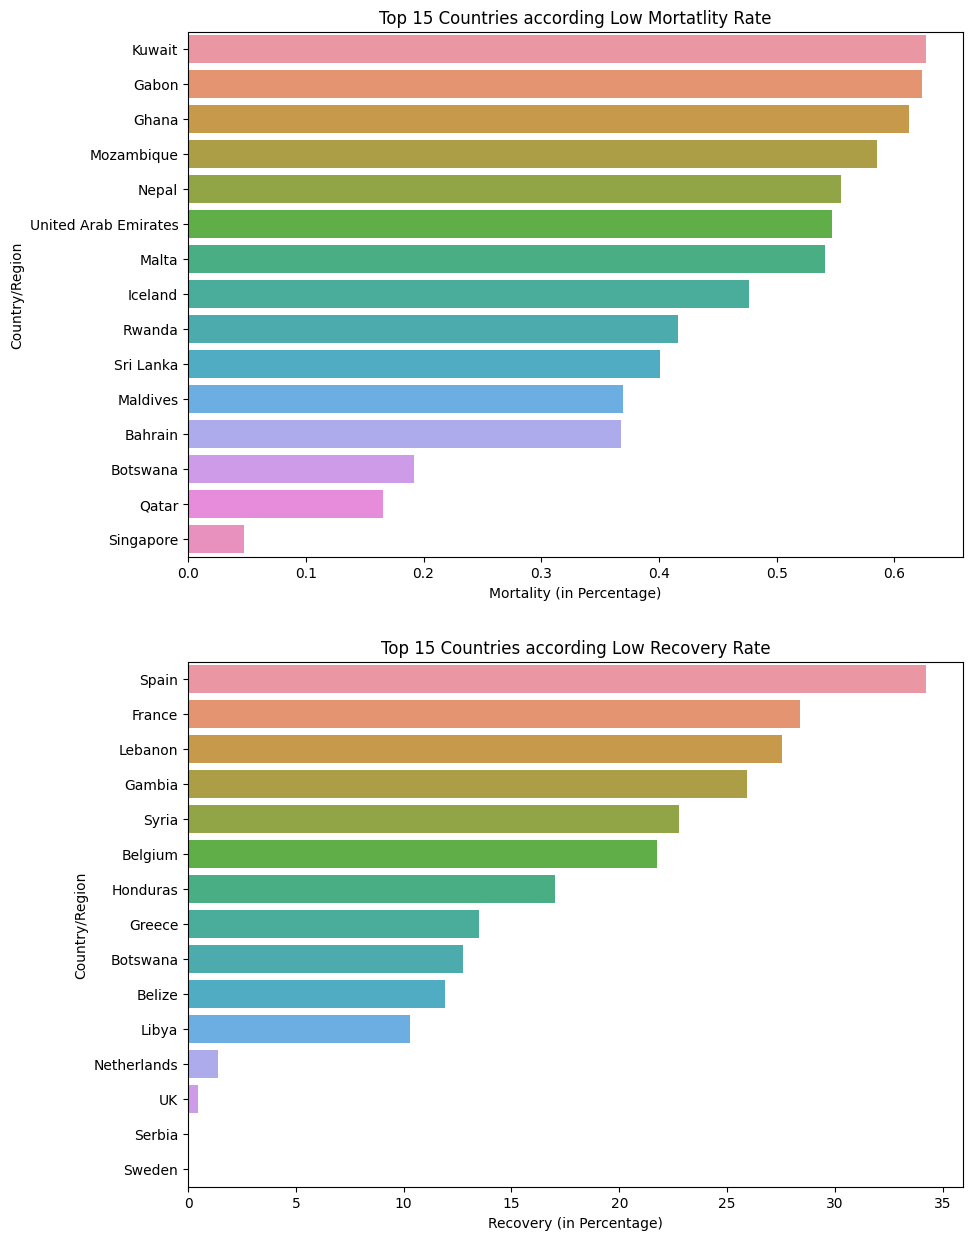

In [279]:
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(10,15))
countrywise_plot_mortal=countrywise[countrywise["Confirmed"]>500].sort_values(["Mortality"],ascending=False).tail(15)
sns.barplot(x=countrywise_plot_mortal["Mortality"],y=countrywise_plot_mortal.index,ax=ax1)
ax1.set_title("Top 15 Countries according Low Mortatlity Rate")
ax1.set_xlabel("Mortality (in Percentage)")
countrywise_plot_recover=countrywise[countrywise["Confirmed"]>500].sort_values(["Recovery"],ascending=False).tail(15)
sns.barplot(x=countrywise_plot_recover["Recovery"],y=countrywise_plot_recover.index, ax=ax2)
ax2.set_title("Top 15 Countries according Low Recovery Rate")
ax2.set_xlabel("Recovery (in Percentage)")

#### No Recovered Patients with considerable Mortality Rate

In [280]:
no_recovered_countries=countrywise[(countrywise["Recovered"]==0)][["Confirmed","Deaths"]]
no_recovered_countries["Mortality Rate"]=(no_recovered_countries["Deaths"]/no_recovered_countries["Confirmed"])*100
no_recovered_countries=no_recovered_countries[no_recovered_countries["Mortality Rate"]>0].sort_values(["Mortality Rate"],ascending=False)
no_recovered_countries.style.background_gradient('Reds')

,Confirmed,Deaths,Mortality Rate
Country/Region,,,
MS Zaandam,9.000000,2.000000,22.222222
Sweden,83958.000000,5821.000000,6.933229
Serbia,31282.000000,710.000000,2.269676


#### Sweden currently has maximum number of Confirmed Cases, with no Recovered patient being recorded, it also has hihgt comparitively has high mortality rate compared to overall mortality rate of the World.

#### Countries with more than 100 Confirmed Cases and No Deaths with considerably high Recovery Rate

In [281]:
no_deaths=countrywise[(countrywise["Confirmed"]>100)&(countrywise["Deaths"]==0)]
no_deaths=no_deaths[no_deaths["Recovery"]>0].sort_values(["Recovery"],ascending=False).drop(["Mortality"],1)
no_deaths.style.background_gradient(cmap="Reds")

,Confirmed,Recovered,Deaths,Recovery
Country/Region,,,,
Mongolia,301.000000,295.000000,0.000000,98.006645
Cambodia,273.000000,265.000000,0.000000,97.069597
Seychelles,136.000000,127.000000,0.000000,93.382353
Eritrea,318.000000,284.000000,0.000000,89.308176
Bhutan,195.000000,135.000000,0.000000,69.230769


#### Vietnam has able to contain COVID-19 pretty well with no Deaths recorded so far with pretty healthy Recovery Rate. Just for information Vietnam was the first country to inform World Health Organization about Human to Human Transmission of COVID-19. 

#### Vietnam and Cambodia will soon be free from COVID-19.

All the above countries are showing amazing recovery rate as well and will be fully completely get over COVID-19 very soon.

Text(0.5, 1.0, 'Top 15 Countries with Most Number of Closed Cases')

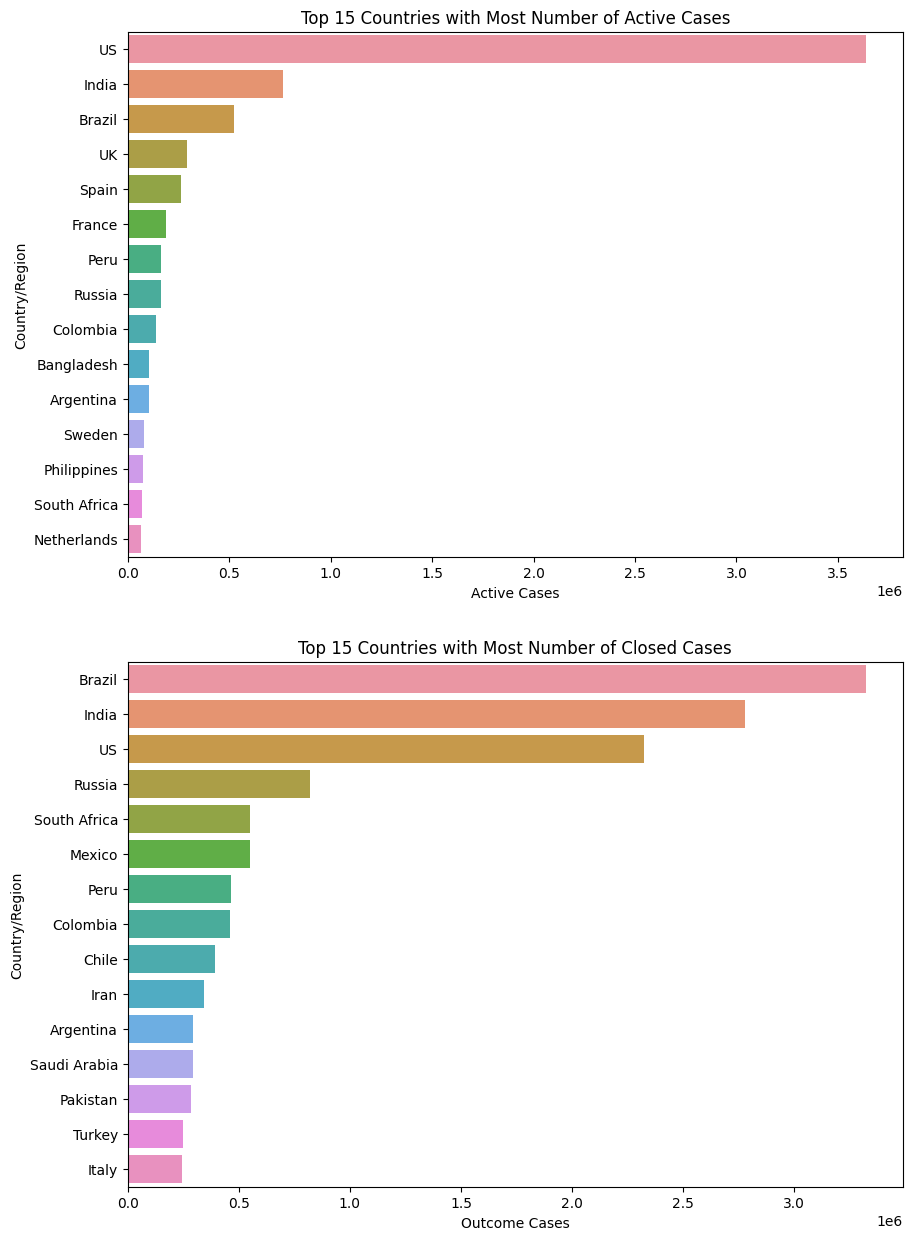

In [282]:
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(10,15))
countrywise["Active Cases"]=(countrywise["Confirmed"]-countrywise["Recovered"]-countrywise["Deaths"])
countrywise["Outcome Cases"]=(countrywise["Recovered"]+countrywise["Deaths"])
top_15_active=countrywise.sort_values(["Active Cases"],ascending=False).head(15)
top_15_outcome=countrywise.sort_values(["Outcome Cases"],ascending=False).head(15)
sns.barplot(x=top_15_active["Active Cases"],y=top_15_active.index,ax=ax1)
sns.barplot(x=top_15_outcome["Outcome Cases"],y=top_15_outcome.index,ax=ax2)
ax1.set_title("Top 15 Countries with Most Number of Active Cases")
ax2.set_title("Top 15 Countries with Most Number of Closed Cases")

In [283]:
country_date=covid.groupby(["Country/Region","ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
confirm_rate=[]
for country in countrywise.index:
    days=country_date.loc[country].shape[0]
    confirm_rate.append((countrywise.loc[country]["Confirmed"])/days)
countrywise["Confirm Cases/Day"]=confirm_rate

Text(0.5, 1.0, 'Top 15 countries as per Lowest Confirmed Cases per Day having more than 1000 Confirmed Cases')

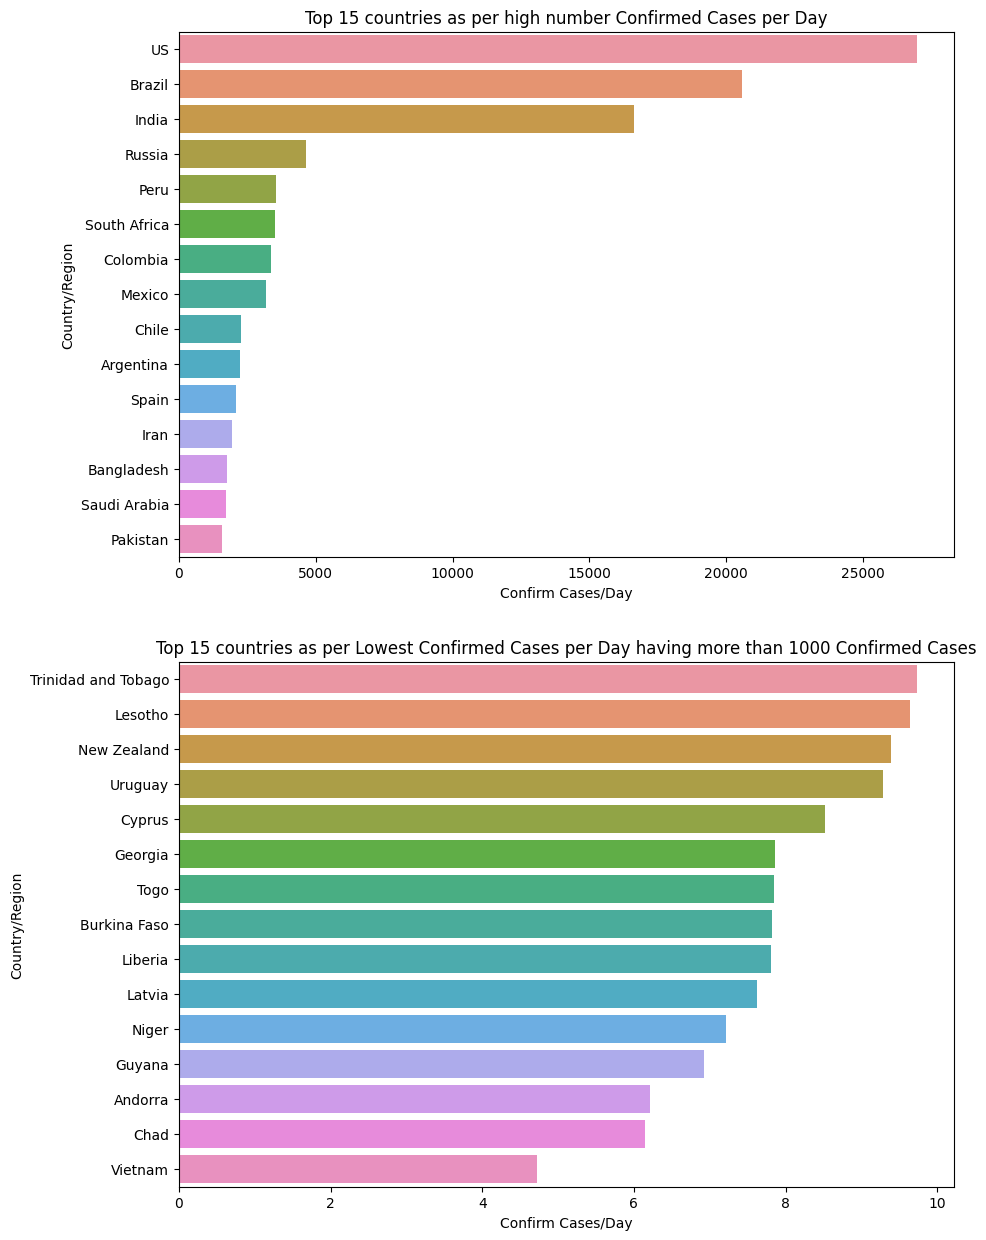

In [284]:
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(10,15))
top_15_ccpd=countrywise.sort_values(["Confirm Cases/Day"],ascending=False).head(15)
sns.barplot(y=top_15_ccpd.index,x=top_15_ccpd["Confirm Cases/Day"],ax=ax1)
ax1.set_title("Top 15 countries as per high number Confirmed Cases per Day")
bottom_15_ccpd=countrywise[countrywise["Confirmed"]>1000].sort_values(["Confirm Cases/Day"],ascending=False).tail(15)
sns.barplot(y=bottom_15_ccpd.index,x=bottom_15_ccpd["Confirm Cases/Day"],ax=ax2)
ax2.set_title("Top 15 countries as per Lowest Confirmed Cases per Day having more than 1000 Confirmed Cases")

#### Mainland China has recorded highest number of Closed cases as thier Recovery Rate is staggering recording 85%+
#### Confirmed Cases/Day is clear indication of why US has highest number of Active Cases currently. The rate is 11000+ cases per day. Showing increase in that value every day.

Mean Survival Probability across all countries 97.1141462840676
Median Survival Probability across all countries 97.91743252359151
Mean Death Probability across all countries 2.8858537159323987
Median Death Probability across all countries 2.082567476408485


Text(0.5, 1.0, 'Bottom 15 Countries as per Survival Probability')

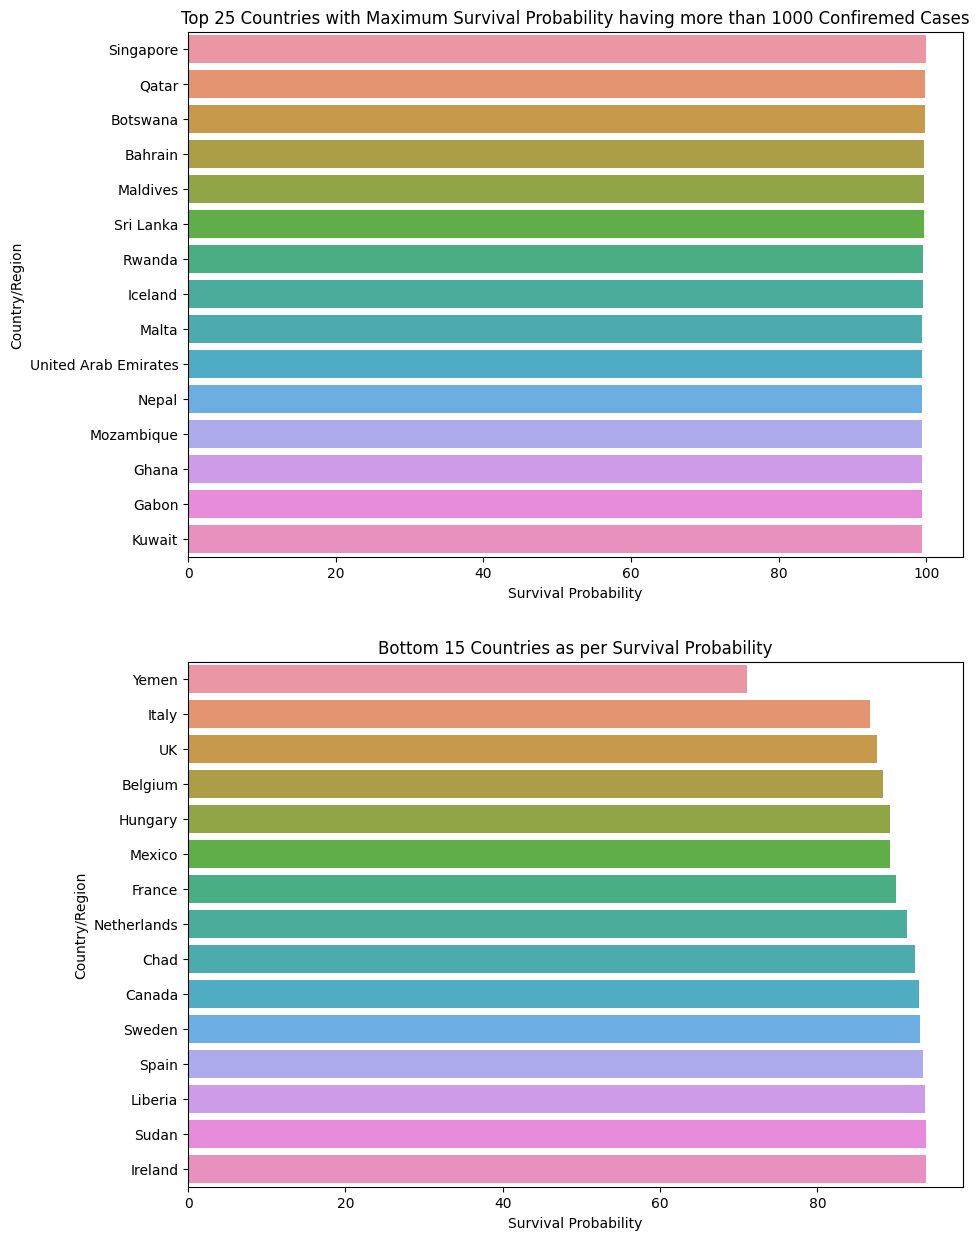

In [285]:
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(10,15))
countrywise["Survival Probability"]=(1-(countrywise["Deaths"]/countrywise["Confirmed"]))*100
top_25_survival=countrywise[countrywise["Confirmed"]>1000].sort_values(["Survival Probability"],ascending=False).head(15)
sns.barplot(x=top_25_survival["Survival Probability"],y=top_25_survival.index,ax=ax1)
ax1.set_title("Top 25 Countries with Maximum Survival Probability having more than 1000 Confiremed Cases")
print('Mean Survival Probability across all countries',countrywise["Survival Probability"].mean())
print('Median Survival Probability across all countries',countrywise["Survival Probability"].median())
print('Mean Death Probability across all countries',100-countrywise["Survival Probability"].mean())
print('Median Death Probability across all countries',100-countrywise["Survival Probability"].median())

Bottom_5_countries=countrywise[countrywise["Confirmed"]>100].sort_values(["Survival Probability"],ascending=True).head(15)
sns.barplot(x=Bottom_5_countries["Survival Probability"],y=Bottom_5_countries.index,ax=ax2)
plt.title("Bottom 15 Countries as per Survival Probability")

#### Survival Probability is the only graph that looks the most promising! Having average survival probability of 95%+ across all countries. The difference between Mean and Median Death Probability is an clear indication that there few countries with really high mortality rate e.g. Italy, Algeria, UK etc.

## Journey of different Countries in COVID-19

#### When we see daily news reports on COVID-19 it's really hard to interpret what's actually happening, since the numbers are changing so rapidly but that's something expected from Exponential growth. Since almost all the pandemics tend to grow exponentially it's really hard to understand for someone from a non-mathematical or non-statistical background.

#### We are more concerned about how we are doing and where we are heading in this pandemic rather than just looking at those exponentially growing numbers. The growth won't be exponentially forever, at some point of time the curve will become flat because probably all the people on the planet are infected or we human have been able to control the disease.

#### When we are in the middle of the exponential growth it's almost impossible to tell where are we heading.

In [286]:
fig=go.Figure()
for country in countrywise.head(10).index:
    fig.add_trace(go.Scatter(x=grouped_country.loc[country]["log_confirmed"], y=grouped_country.loc[country]["log_active"],
                    mode='lines',name=country))
fig.update_layout(height=600,title="COVID-19 Journey of Top 15 Worst Affected Countries",
                 xaxis_title="Confirmed Cases (Logrithmic Scale)",yaxis_title="Active Cases (Logarithmic Scale)",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

It's pretty evident that the disease is spreading in same manner everywhere, but if particular country is following pandemic controlling practices rigrously the results are evident in the graph.

Most of the countries will follow the same trajectory as that USA, which is **"Uncontrolled Exponential Growth"** 

There are few countries where the pandemic controlling practices seems to be working accurately, few classic examples are China, Germany, Italy, Spain, Turkey has started showing that dip indicating there are somehow got control over COVID-19

Countries like United Kingdom, Russia are following similar lines as that of United States, indicating the growth is still exponential among those countries.

Iran is showing some occasional drops.

In [287]:
fig=go.Figure()
for country in countrywise.head(10).index:
    fig.add_trace(go.Scatter(x=grouped_country.loc[country].index, y=grouped_country.loc[country]["Confirmed"].rolling(window=7).mean().diff(),
                    mode='lines',name=country))
fig.update_layout(height=600,title="7 Days Rolling Average of Daily increase of Confirmed Cases",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [288]:
fig=go.Figure()
for country in countrywise.head(10).index:
    fig.add_trace(go.Scatter(x=grouped_country.loc[country].index, 
                             y=grouped_country.loc[country]["Deaths"].rolling(window=7).mean().diff(),
                    mode='lines',name=country))
fig.update_layout(height=600,title="7 Days Rolling Average of Daily increase of Death Cases",
                 xaxis_title="Date",yaxis_title="Death Cases",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [289]:
fig=go.Figure()
for country in countrywise.head(10).index:
    fig.add_trace(go.Scatter(x=grouped_country.loc[country].index, 
                             y=grouped_country.loc[country]["Recovered"].rolling(window=7).mean().diff(),
                    mode='lines',name=country))
fig.update_layout(height=600,title="7 Days Rolling Average of Daily increase of Recovered Cases",
                 xaxis_title="Date",yaxis_title="Recovered Cases",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

## Clustering of Countries

The clustering of countries can be done considering different features. Here I'm trying to cluster different countries based on the Mortality and Recovery rate of indivisual country.

As we all are well aware that COVID-19 has different Mortality Rate among different countries based on different factors and so is the Recovery Rate because of pandemic controlling practices followed by the individual country. Also Mortality Rate and Recovery Rate both togther takes into account all types of cases Confirmed, Recoverd and Deaths.

Let's checkout how these clusters look like!

In [290]:
X=countrywise[["Mortality","Recovery"]]
#Standard Scaling since K-Means Clustering is a distance based alogrithm
X=std.fit_transform(X) 

In [291]:
wcss=[]
sil=[]
for i in range(2,11):
    clf=KMeans(n_clusters=i,init='k-means++',random_state=42)
    clf.fit(X)
    labels=clf.labels_
    centroids=clf.cluster_centers_
    sil.append(silhouette_score(X, labels, metric='euclidean'))
    wcss.append(clf.inertia_)

Text(0.5, 1.0, 'Elbow Method')

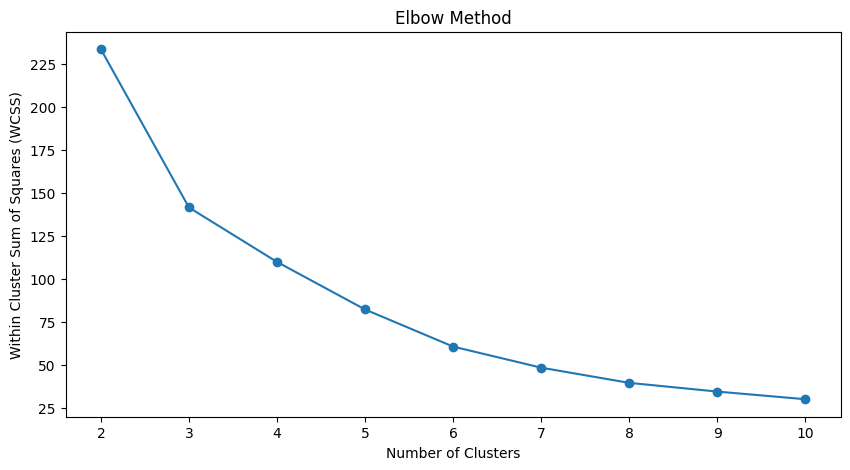

In [292]:
x=np.arange(2,11)
plt.figure(figsize=(10,5))
plt.plot(x,wcss,marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Within Cluster Sum of Squares (WCSS)")
plt.title("Elbow Method")

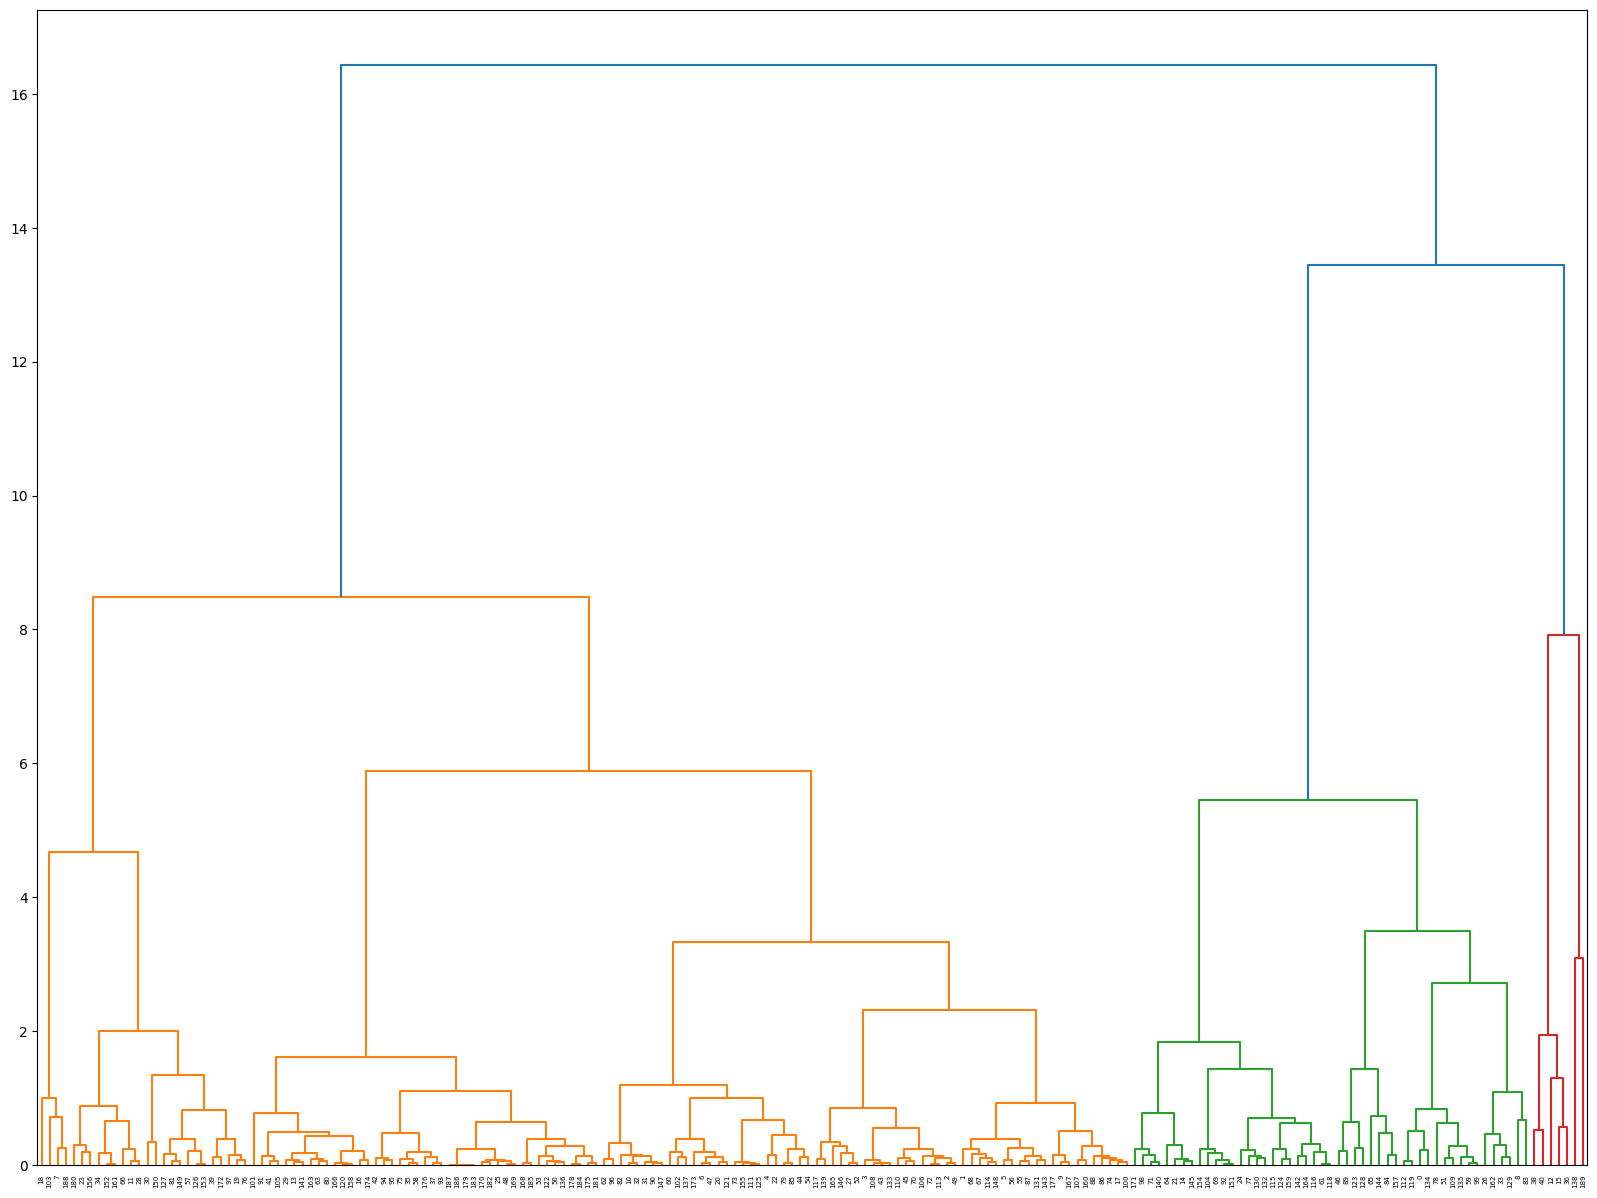

In [293]:
import scipy.cluster.hierarchy as sch
plt.figure(figsize=(20,15))
dendogram=sch.dendrogram(sch.linkage(X, method  = "ward"))

All methods namely Elbow Method and Hierarchical Clustering shows **K=3** will correct number of clusters.

In [294]:
clf_final=KMeans(n_clusters=3,init='k-means++',random_state=6)
clf_final.fit(X)

KMeans(n_clusters=3, random_state=6)

In [295]:
countrywise["Clusters"]=clf_final.predict(X)

#### Summary of Clusters

In [296]:
cluster_summary=pd.concat([countrywise[countrywise["Clusters"]==1].head(15),countrywise[countrywise["Clusters"]==2].head(15),countrywise[countrywise["Clusters"]==0].head(15)])
cluster_summary.style.background_gradient(cmap='Reds').format("{:.2f}")

,Confirmed,Recovered,Deaths,Mortality,Recovery,Active Cases,Outcome Cases,Confirm Cases/Day,Survival Probability,Clusters
Country/Region,,,,,,,,,,
Mexico,591712.00,484283.00,63819.00,10.79,81.84,43610.00,548102.00,3198.44,89.21,1.00
UK,334916.00,1622.00,41585.00,12.42,0.48,291709.00,43207.00,1579.79,87.58,1.00
France,304947.00,86495.00,30601.00,10.03,28.36,187851.00,117096.00,1392.45,89.97,1.00
Italy,266853.00,208224.00,35473.00,13.29,78.03,23156.00,243697.00,1258.74,86.71,1.00
Belgium,84599.00,18403.00,9891.00,11.69,21.75,56305.00,28294.00,406.73,88.31,1.00
Netherlands,72128.00,986.00,6252.00,8.67,1.37,64890.00,7238.00,389.88,91.33,1.00
Hungary,5669.00,3759.00,614.00,10.83,66.31,1296.00,4373.00,31.67,89.17,1.00
Yemen,1946.00,1113.00,563.00,28.93,57.19,270.00,1676.00,13.70,71.07,1.00
Western Sahara,10.00,8.00,1.00,10.00,80.00,1.00,9.00,0.07,90.00,1.00


In [297]:
print("Avergae Mortality Rate of Cluster 0: ",countrywise[countrywise["Clusters"]==0]["Mortality"].mean())
print("Avergae Recovery Rate of Cluster 0: ",countrywise[countrywise["Clusters"]==0]["Recovery"].mean())
print("Avergae Mortality Rate of Cluster 1: ",countrywise[countrywise["Clusters"]==1]["Mortality"].mean())
print("Avergae Recovery Rate of Cluster 1: ",countrywise[countrywise["Clusters"]==1]["Recovery"].mean())
print("Avergae Mortality Rate of Cluster 2: ",countrywise[countrywise["Clusters"]==2]["Mortality"].mean())
print("Avergae Recovery Rate of Cluster 2: ",countrywise[countrywise["Clusters"]==2]["Recovery"].mean())

Avergae Mortality Rate of Cluster 0:  2.2463194361559777
Avergae Recovery Rate of Cluster 0:  83.75183966895968
Avergae Mortality Rate of Cluster 1:  13.887372332715879
Avergae Recovery Rate of Cluster 1:  41.534456148992625
Avergae Mortality Rate of Cluster 2:  2.3649469755029395
Avergae Recovery Rate of Cluster 2:  39.4954479457303


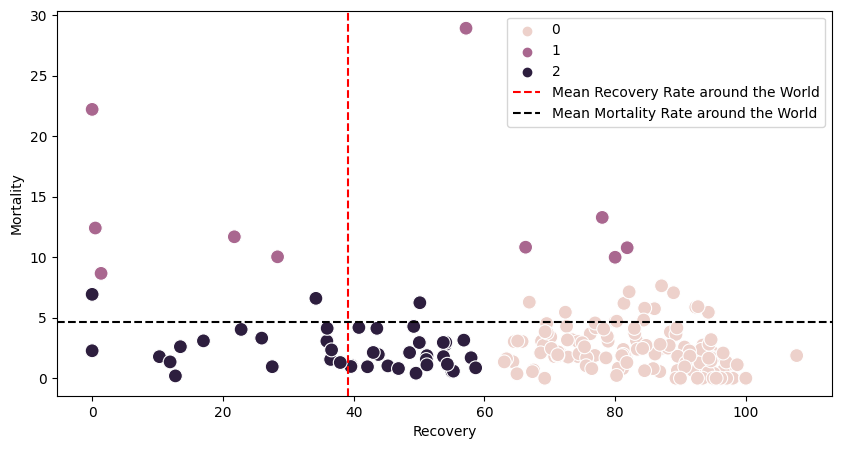

In [298]:
plt.figure(figsize=(10,5))
sns.scatterplot(x=countrywise["Recovery"],y=countrywise["Mortality"],hue=countrywise["Clusters"],s=100)
plt.axvline(((datewise["Recovered"]/datewise["Confirmed"])*100).mean(),
            color='red',linestyle="--",label="Mean Recovery Rate around the World")
plt.axhline(((datewise["Deaths"]/datewise["Confirmed"])*100).mean(),
            color='black',linestyle="--",label="Mean Mortality Rate around the World")
plt.legend()

In [299]:
print("Few Countries belonging to Cluster 0: ",list(countrywise[countrywise["Clusters"]==0].head(10).index))
print("Few Countries belonging to Cluster 1: ",list(countrywise[countrywise["Clusters"]==1].head(10).index))
print("Few Countries belonging to Cluster 2: ",list(countrywise[countrywise["Clusters"]==2].head(10).index))

Few Countries belonging to Cluster 0:  ['Brazil', 'India', 'Russia', 'Peru', 'South Africa', 'Colombia', 'Chile', 'Argentina', 'Iran', 'Saudi Arabia']
Few Countries belonging to Cluster 1:  ['Mexico', 'UK', 'France', 'Italy', 'Belgium', 'Netherlands', 'Hungary', 'Yemen', 'Western Sahara', 'MS Zaandam']
Few Countries belonging to Cluster 2:  ['US', 'Spain', 'Ukraine', 'Bolivia', 'Romania', 'Sweden', 'Honduras', 'Ethiopia', 'Costa Rica', 'Nepal']


Cluster 2 is a set of countries which have really **High Mortality Rate** and consdierably **Good Recovery Rate**. Basically few countries among these clusters have seen already the worst of this pandemic but are now recovering with healty Recovery Rate.

Cluster 0 is set of countries which have **Low Mortality Rate** and really **High Recovery Rate**. These are the set of countries who has been able to control the COVID-19 by following pandemic controlling practices rigorously. 

Cluster 1 is set of countries which have **Low Mortality Rate** and really **Low Recovery Rate**. These countries need to pace up their Revovery Rate to get out it, Some thses countries have really high number of Infected Cases but Low Mortality is positive sign out of it.

### Comparison of China, Italy, US, Spain, Brazil and Rest of the World

In [300]:
china_data=covid[covid["Country/Region"]=="Mainland China"]
Italy_data=covid[covid["Country/Region"]=="Italy"]
US_data=covid[covid["Country/Region"]=="US"]
spain_data=covid[covid["Country/Region"]=="Spain"]
brazil_data=covid[covid["Country/Region"]=="Brazil"]
rest_of_world=covid[(covid["Country/Region"]!="Mainland China")&(covid["Country/Region"]!="Italy")&(covid["Country/Region"]!="US")&(covid["Country/Region"]!="Spain")&(covid["Country/Region"]!="Brazil")]

datewise_china=china_data.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
datewise_Italy=Italy_data.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
datewise_US=US_data.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
datewise_Spain=spain_data.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
datewise_Brazil=brazil_data.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
datewise_restofworld=rest_of_world.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})

In [301]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise_china.index, y=(datewise_china["Confirmed"]),
                    mode='lines',name="China"))
fig.add_trace(go.Scatter(x=datewise_Italy.index, y=(datewise_Italy["Confirmed"]),
                    mode='lines',name="Italy"))
fig.add_trace(go.Scatter(x=datewise_US.index, y=(datewise_US["Confirmed"]),
                    mode='lines',name="United States"))
fig.add_trace(go.Scatter(x=datewise_Spain.index, y=(datewise_Spain["Confirmed"]),
                    mode='lines',name="Spain"))
fig.add_trace(go.Scatter(x=datewise_Brazil.index, y=(datewise_Brazil["Confirmed"]),
                    mode='lines',name="Brazil"))
fig.add_trace(go.Scatter(x=datewise_restofworld.index, y=(datewise_restofworld["Confirmed"]),
                    mode='lines',name="Rest of the World"))
fig.update_layout(title="Confirmed Cases plot",
                  xaxis_title="Date",yaxis_title="Number of Cases",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [302]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise_china.index, y=(datewise_china["Recovered"]),
                    mode='lines',name="China"))
fig.add_trace(go.Scatter(x=datewise_Italy.index, y=(datewise_Italy["Recovered"]),
                    mode='lines',name="Italy"))
fig.add_trace(go.Scatter(x=datewise_US.index, y=(datewise_US["Recovered"]),
                    mode='lines',name="United States"))
fig.add_trace(go.Scatter(x=datewise_Spain.index, y=(datewise_Spain["Recovered"]),
                    mode='lines',name="Spain"))
fig.add_trace(go.Scatter(x=datewise_Brazil.index, y=(datewise_Brazil["Recovered"]),
                    mode='lines',name="Brazil"))
fig.add_trace(go.Scatter(x=datewise_restofworld.index, y=(datewise_restofworld["Recovered"]),
                    mode='lines',name="Rest of the World"))
fig.update_layout(title="Recovered Cases plot",
                  xaxis_title="Date",yaxis_title="Number of Cases",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [303]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise_china.index, y=(datewise_china["Deaths"]),
                    mode='lines',name="China"))
fig.add_trace(go.Scatter(x=datewise_Italy.index, y=(datewise_Italy["Deaths"]),
                    mode='lines',name="Italy"))
fig.add_trace(go.Scatter(x=datewise_US.index, y=(datewise_US["Deaths"]),
                    mode='lines',name="United States"))
fig.add_trace(go.Scatter(x=datewise_Spain.index, y=(datewise_Spain["Deaths"]),
                    mode='lines',name="Spain"))
fig.add_trace(go.Scatter(x=datewise_Brazil.index, y=(datewise_Brazil["Deaths"]),
                    mode='lines',name="Brazil"))
fig.add_trace(go.Scatter(x=datewise_restofworld.index, y=(datewise_restofworld["Deaths"]),
                    mode='lines',name="Rest of the World"))
fig.update_layout(title="Death Cases plot",
                  xaxis_title="Date",yaxis_title="Number of Cases",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

#### China has been able to "flatten the curve" looking at their graphs of Confirmed and Death Cases. With staggering Recovery Rate.
#### US seems to have good control on Deaths, but number of people getting affected is going way out of hand.

In [304]:
datewise_china["Mortality"]=(datewise_china["Deaths"]/datewise_china["Confirmed"])*100
datewise_Italy["Mortality"]=(datewise_Italy["Deaths"]/datewise_Italy["Confirmed"])*100
datewise_US["Mortality"]=(datewise_US["Deaths"]/datewise_US["Confirmed"])*100
datewise_Spain["Mortality"]=(datewise_Spain["Deaths"]/datewise_Spain["Confirmed"])*100
datewise_Brazil["Mortality"]=(datewise_Brazil["Deaths"]/datewise_Brazil["Confirmed"])*100
datewise_restofworld["Mortality"]=(datewise_restofworld["Deaths"]/datewise_restofworld["Confirmed"])*100

datewise_china["Recovery"]=(datewise_china["Recovered"]/datewise_china["Confirmed"])*100
datewise_Italy["Recovery"]=(datewise_Italy["Recovered"]/datewise_Italy["Confirmed"])*100
datewise_US["Recovery"]=(datewise_US["Recovered"]/datewise_US["Confirmed"])*100
datewise_Spain["Recovery"]=(datewise_Spain["Recovered"]/datewise_Spain["Confirmed"])*100
datewise_Brazil["Recovery"]=(datewise_Brazil["Recovered"]/datewise_Brazil["Confirmed"])*100
datewise_restofworld["Recovery"]=(datewise_restofworld["Recovered"]/datewise_restofworld["Confirmed"])*100

In [305]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise_china.index, y=(datewise_china["Mortality"]),
                    mode='lines',name="China"))
fig.add_trace(go.Scatter(x=datewise_Italy.index, y=(datewise_Italy["Mortality"]),
                    mode='lines',name="Italy"))
fig.add_trace(go.Scatter(x=datewise_US.index, y=(datewise_US["Mortality"]),
                    mode='lines',name="United States"))
fig.add_trace(go.Scatter(x=datewise_Spain.index, y=(datewise_Spain["Mortality"]),
                    mode='lines',name="Spain"))
fig.add_trace(go.Scatter(x=datewise_Brazil.index, y=(datewise_Brazil["Mortality"]),
                    mode='lines',name="Brazil"))
fig.add_trace(go.Scatter(x=datewise_restofworld.index, y=(datewise_restofworld["Mortality"]),
                    mode='lines',name="Rest of the World"))
fig.update_layout(title="Mortality Rate comparison plot",
                  xaxis_title="Date",yaxis_title="Mortality Rate",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [306]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise_china.index, y=(datewise_china["Recovery"]),
                    mode='lines',name="China"))
fig.add_trace(go.Scatter(x=datewise_Italy.index, y=(datewise_Italy["Recovery"]),
                    mode='lines',name="Italy"))
fig.add_trace(go.Scatter(x=datewise_US.index, y=(datewise_US["Recovery"]),
                    mode='lines',name="United States"))
fig.add_trace(go.Scatter(x=datewise_Spain.index, y=(datewise_Spain["Recovery"]),
                    mode='lines',name="Spain"))
fig.add_trace(go.Scatter(x=datewise_Brazil.index, y=(datewise_Brazil["Recovery"]),
                    mode='lines',name="Brazil"))
fig.add_trace(go.Scatter(x=datewise_restofworld.index, y=(datewise_restofworld["Recovery"]),
                    mode='lines',name="Rest of the World"))
fig.update_layout(title="Recovery Rate comparison plot",
                  xaxis_title="Date",yaxis_title="Recovery Rate",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

#### Taking off Recovery Rate of Spain is a good sign but it's nowhere in comparison to the Moratality Rate.
#### Its alarming sign for USA and Brazil as their Recovery Rate is improving considerably as compared to other severly affected countries.

In [307]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise_china.index, y=(datewise_china["Confirmed"]).diff().fillna(0),
                    mode='lines',name="China"))
fig.add_trace(go.Scatter(x=datewise_Italy.index, y=(datewise_Italy["Confirmed"]).diff().fillna(0),
                    mode='lines',name="Italy"))
fig.add_trace(go.Scatter(x=datewise_US.index, y=(datewise_US["Confirmed"]).diff().fillna(0),
                    mode='lines',name="United States"))
fig.add_trace(go.Scatter(x=datewise_Spain.index, y=(datewise_Spain["Confirmed"]).diff().fillna(0),
                    mode='lines',name="Spain"))
fig.add_trace(go.Scatter(x=datewise_Brazil.index, y=(datewise_Brazil["Confirmed"]).diff().fillna(0),
                    mode='lines',name="Brazil"))
fig.add_trace(go.Scatter(x=datewise_restofworld.index, y=(datewise_restofworld["Confirmed"]).diff().fillna(0),
                    mode='lines',name="Rest of the World"))
fig.update_layout(title="Daily increase in Number of Confirmed Cases",
                  xaxis_title="Date",yaxis_title="Number of Cases",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [308]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise_china.index, y=(datewise_china["Deaths"]).diff().fillna(0),
                    mode='lines',name="China"))
fig.add_trace(go.Scatter(x=datewise_Italy.index, y=(datewise_Italy["Deaths"]).diff().fillna(0),
                    mode='lines',name="Italy"))
fig.add_trace(go.Scatter(x=datewise_US.index, y=(datewise_US["Deaths"]).diff().fillna(0),
                    mode='lines',name="United States"))
fig.add_trace(go.Scatter(x=datewise_Spain.index, y=(datewise_Spain["Deaths"]).diff().fillna(0),
                    mode='lines',name="Spain"))
fig.add_trace(go.Scatter(x=datewise_Brazil.index, y=(datewise_Brazil["Deaths"]).diff().fillna(0),
                    mode='lines',name="Brazil"))
fig.add_trace(go.Scatter(x=datewise_restofworld.index, y=(datewise_restofworld["Deaths"]).diff().fillna(0),
                    mode='lines',name="Rest of the World"))
fig.update_layout(title="Daily increase in Number of Death Cases",
                  xaxis_title="Date",yaxis_title="Number of Cases",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

#### We can clearly notice the decreasing trend in the number of Daily Confirmed and Death Cases of Spain and Italy. That's really positive sign for both the countries. 

## Data Analysis for India 

The notebook consists of detailed data analysis specific to India, Comparison of India with the neighboring countries, Comparison with worst affected countries in this pandemic and try and build Machine Learnig Prediction and Time Series and Forecasting models to try and understand the how the numbers are going to be in near future.

In [309]:
india_data=covid[covid["Country/Region"]=="India"]
datewise_india=india_data.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
print(datewise_india.iloc[-1])
print("Total Active Cases: ",datewise_india["Confirmed"].iloc[-1]-datewise_india["Recovered"].iloc[-1]-datewise_india["Deaths"].iloc[-1])
print("Total Closed Cases: ",datewise_india["Recovered"].iloc[-1]+datewise_india["Deaths"].iloc[-1])

Confirmed   3542733.000000
Recovered   2713933.000000
Deaths        63498.000000
Name: 2020-08-29 00:00:00, dtype: float64
Total Active Cases:  765302.0
Total Closed Cases:  2777431.0


In [310]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise_india.index, y=datewise_india["Confirmed"],
                    mode='lines+markers',
                    name='Confirmed Cases'))
fig.add_trace(go.Scatter(x=datewise_india.index, y=datewise_india["Recovered"],
                    mode='lines+markers',
                    name='Recovered Cases'))
fig.add_trace(go.Scatter(x=datewise_india.index, y=datewise_india["Deaths"],
                    mode='lines+markers',
                    name='Death Cases'))
fig.update_layout(title="Growth of different types of cases in India",
                 xaxis_title="Date",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [311]:
fig=px.bar(x=datewise_india.index,y=datewise_india["Confirmed"]-datewise_india["Recovered"]-datewise_india["Deaths"])
fig.update_layout(title="Distribution of Number of Active Cases in India",
                  xaxis_title="Date",yaxis_title="Number of Cases",)
fig.show()

In [312]:
india_increase_confirm=[]
india_increase_recover=[]
india_increase_deaths=[]
for i in range(datewise_india.shape[0]-1):
    india_increase_confirm.append(((datewise_india["Confirmed"].iloc[i+1])/datewise_india["Confirmed"].iloc[i]))
    india_increase_recover.append(((datewise_india["Recovered"].iloc[i+1])/datewise_india["Recovered"].iloc[i]))
    india_increase_deaths.append(((datewise_india["Deaths"].iloc[i+1])/datewise_india["Deaths"].iloc[i]))
india_increase_confirm.insert(0,1)
india_increase_recover.insert(0,1)
india_increase_deaths.insert(0,1)

fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise_india.index, y=india_increase_confirm,
                    mode='lines',
                    name='Growth Factor of Confirmed Cases'))
fig.add_trace(go.Scatter(x=datewise_india.index, y=india_increase_recover,
                    mode='lines',
                    name='Growth Factor of Recovered Cases'))
fig.add_trace(go.Scatter(x=datewise_india.index, y=india_increase_deaths,
                    mode='lines',
                    name='Growth Factor of Death Cases'))
fig.update_layout(title="Datewise Growth Factor of Active and Closed cases in India",
                 xaxis_title="Date",yaxis_title="Growth Factor",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [313]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise_india.index, y=datewise_india["Confirmed"].diff().fillna(0),
                    mode='lines+markers',
                    name='Confirmed Cases'))
fig.add_trace(go.Scatter(x=datewise_india.index, y=datewise_india["Recovered"].diff().fillna(0),
                    mode='lines+markers',
                    name='Recovered Cases'))
fig.add_trace(go.Scatter(x=datewise_india.index, y=datewise_india["Deaths"].diff().fillna(0),
                    mode='lines+markers',
                    name='Death Cases'))
fig.update_layout(title="Daily increase in different types of cases in India",
                 xaxis_title="Date",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [314]:
datewise_india["WeekOfYear"]=datewise_india.index.weekofyear

week_num_india=[]
india_weekwise_confirmed=[]
india_weekwise_recovered=[]
india_weekwise_deaths=[]
w=1
for i in list(datewise_india["WeekOfYear"].unique()):
    india_weekwise_confirmed.append(datewise_india[datewise_india["WeekOfYear"]==i]["Confirmed"].iloc[-1])
    india_weekwise_recovered.append(datewise_india[datewise_india["WeekOfYear"]==i]["Recovered"].iloc[-1])
    india_weekwise_deaths.append(datewise_india[datewise_india["WeekOfYear"]==i]["Deaths"].iloc[-1])
    week_num_india.append(w)
    w=w+1
    
fig=go.Figure()
fig.add_trace(go.Scatter(x=week_num_india, y=india_weekwise_confirmed,
                    mode='lines+markers',
                    name='Weekly Growth of Confirmed Cases'))
fig.add_trace(go.Scatter(x=week_num_india, y=india_weekwise_recovered,
                    mode='lines+markers',
                    name='Weekly Growth of Recovered Cases'))
fig.add_trace(go.Scatter(x=week_num_india, y=india_weekwise_deaths,
                    mode='lines+markers',
                    name='Weekly Growth of Death Cases'))
fig.update_layout(title="Weekly Growth of different types of Cases in India",
                 xaxis_title="Week Number",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

Text(0.5, 1.0, "India's Weekwise increase in Number of Death Cases")

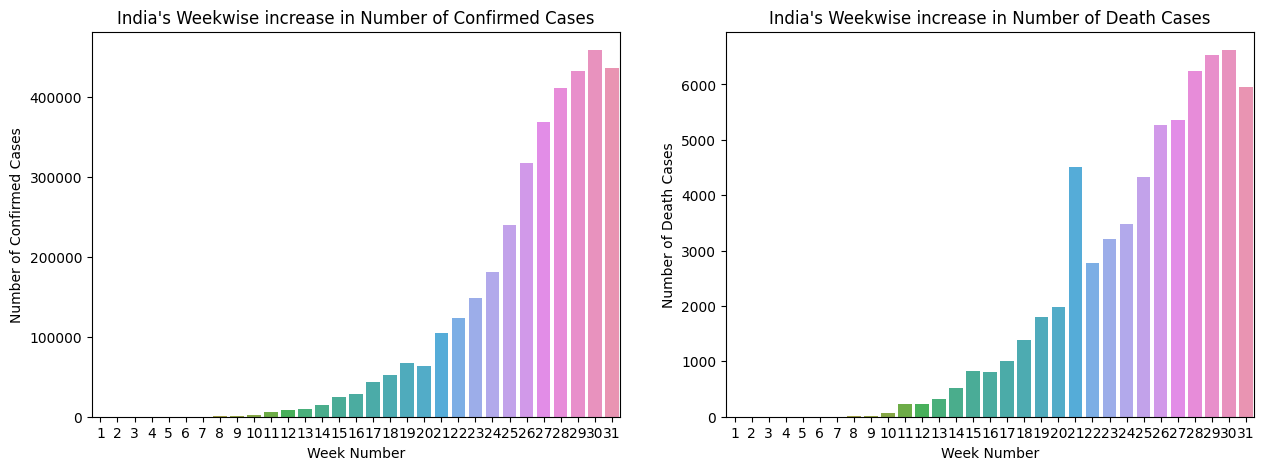

In [315]:
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5))
sns.barplot(x=week_num_india,y=pd.Series(india_weekwise_confirmed).diff().fillna(0),ax=ax1)
sns.barplot(x=week_num_india,y=pd.Series(india_weekwise_deaths).diff().fillna(0),ax=ax2)
ax1.set_xlabel("Week Number")
ax2.set_xlabel("Week Number")
ax1.set_ylabel("Number of Confirmed Cases")
ax2.set_ylabel("Number of Death Cases")
ax1.set_title("India's Weekwise increase in Number of Confirmed Cases")
ax2.set_title("India's Weekwise increase in Number of Death Cases")

In [316]:
max_ind=datewise_india["Confirmed"].max()

print("It took",datewise_Italy[(datewise_Italy["Confirmed"]>0)&(datewise_Italy["Confirmed"]<=max_ind)].shape[0],"days in Italy to reach number of Confirmed Cases equivalent to India")
print("It took",datewise_US[(datewise_US["Confirmed"]>0)&(datewise_US["Confirmed"]<=max_ind)].shape[0],"days in USA to reach number of Confirmed Cases equivalent to India")
print("It took",datewise_Spain[(datewise_Spain["Confirmed"]>0)&(datewise_Spain["Confirmed"]<=max_ind)].shape[0],"days in Spain to reach number of Confirmed Cases equivalent to India")
print("It took",datewise_india[datewise_india["Confirmed"]>0].shape[0],"days in India to reach",max_ind,"Confirmed Cases")

fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise_Italy[(datewise_Italy["Confirmed"]>0)&(datewise_Italy["Confirmed"]<=max_ind)].index, y=datewise_Italy[(datewise_Italy["Confirmed"]>0)&(datewise_Italy["Confirmed"]<=max_ind)]["Confirmed"],
                    mode='lines',name="Italy"))
fig.add_trace(go.Scatter(x=datewise_US[(datewise_US["Confirmed"]>0)&(datewise_US["Confirmed"]<=max_ind)].index, y=datewise_US[(datewise_US["Confirmed"]>0)&(datewise_US["Confirmed"]<=max_ind)]["Confirmed"],
                    mode='lines',name="USA"))
fig.add_trace(go.Scatter(x=datewise_Spain[(datewise_Spain["Confirmed"]>0)&(datewise_Spain["Confirmed"]<=max_ind)].index, y=datewise_Spain[(datewise_Spain["Confirmed"]>0)&(datewise_Spain["Confirmed"]<=max_ind)]["Confirmed"],
                    mode='lines',name="Spain"))
fig.add_trace(go.Scatter(x=datewise_india.index, y=datewise_india["Confirmed"],
                    mode='lines',name="India"))
fig.update_layout(title="Growth of Recovered Cases with respect to India",
                 xaxis_title="Date",yaxis_title="Number of Confirmed Cases",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

It took 212 days in Italy to reach number of Confirmed Cases equivalent to India
It took 176 days in USA to reach number of Confirmed Cases equivalent to India
It took 211 days in Spain to reach number of Confirmed Cases equivalent to India
It took 213 days in India to reach 3542733.0 Confirmed Cases


#### Comparison of Daily Increase in Number of Cases of Italy, Spain, USA and India, where maximum number of Confirmed Cases are equivalent to maximum number of Confirmed Cases in India

In [317]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise_Italy[(datewise_Italy["Confirmed"]>0)&(datewise_Italy["Confirmed"]<=max_ind)].index, 
                         y=datewise_Italy[(datewise_Italy["Confirmed"]>0)&(datewise_Italy["Confirmed"]<=max_ind)]["Confirmed"].diff().fillna(0),
                    mode='lines',name="Italy"))
fig.add_trace(go.Scatter(x=datewise_US[(datewise_US["Confirmed"]>0)&(datewise_US["Confirmed"]<=max_ind)].index, 
                         y=datewise_US[(datewise_US["Confirmed"]>0)&(datewise_US["Confirmed"]<=max_ind)]["Confirmed"].diff().fillna(0),
                    mode='lines',name="USA"))
fig.add_trace(go.Scatter(x=datewise_Spain[(datewise_Spain["Confirmed"]>0)&(datewise_Spain["Confirmed"]<=max_ind)].index,
                         y=datewise_Spain[(datewise_Spain["Confirmed"]>0)&(datewise_Spain["Confirmed"]<=max_ind)]["Confirmed"].diff().fillna(0),
                    mode='lines',name="Spain"))
fig.add_trace(go.Scatter(x=datewise_india.index, y=datewise_india["Confirmed"].diff().fillna(0),
                    mode='lines',name="India"))
fig.update_layout(title="Daily increase in Confirmed Cases",
                 xaxis_title="Date",yaxis_title="Number of Confirmed Cases",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

## Prediction using Machine Learning Models

#### Linear Regression Model for Confirm Cases Prediction

In [318]:
datewise["Days Since"]=datewise.index-datewise.index[0]
datewise["Days Since"]=datewise["Days Since"].dt.days

In [319]:
train_ml=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid_ml=datewise.iloc[int(datewise.shape[0]*0.95):]
model_scores=[]

In [320]:
lin_reg=LinearRegression()

In [321]:
lin_reg.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["Confirmed"]).reshape(-1,1))

LinearRegression()

In [322]:
prediction_valid_linreg=lin_reg.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))

In [323]:
model_scores.append(np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_linreg)))
print("Root Mean Square Error for Linear Regression: ",np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_linreg)))

Root Mean Square Error for Linear Regression:  6783550.068817438


In [324]:
plt.figure(figsize=(11,6))
prediction_linreg=lin_reg.predict(np.array(datewise["Days Since"]).reshape(-1,1))
linreg_output=[]
for i in range(prediction_linreg.shape[0]):
    linreg_output.append(prediction_linreg[i][0])

fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=datewise.index, y=linreg_output,
                    mode='lines',name="Linear Regression Best Fit Line",
                    line=dict(color='black', dash='dot')))
fig.update_layout(title="Confirmed Cases Linear Regression Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

<Figure size 1100x600 with 0 Axes>

#### The Linear Regression Model is absolutely falling aprat. As it is clearly visible that the trend of Confirmed Cases in absolutely not Linear.

#### Polynomial Regression for Prediction of Confirmed Cases

In [325]:
train_ml=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid_ml=datewise.iloc[int(datewise.shape[0]*0.95):]

In [326]:
poly = PolynomialFeatures(degree = 8) 

In [327]:
train_poly=poly.fit_transform(np.array(train_ml["Days Since"]).reshape(-1,1))
valid_poly=poly.fit_transform(np.array(valid_ml["Days Since"]).reshape(-1,1))
y=train_ml["Confirmed"]

In [328]:
linreg=LinearRegression()
linreg.fit(train_poly,y)

LinearRegression()

In [329]:
prediction_poly=linreg.predict(valid_poly)
rmse_poly=np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_poly))
model_scores.append(rmse_poly)
print("Root Mean Squared Error for Polynomial Regression: ",rmse_poly)

Root Mean Squared Error for Polynomial Regression:  131416.90865566215


In [330]:
comp_data=poly.fit_transform(np.array(datewise["Days Since"]).reshape(-1,1))
plt.figure(figsize=(11,6))
predictions_poly=linreg.predict(comp_data)

fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=datewise.index, y=predictions_poly,
                    mode='lines',name="Polynomial Regression Best Fit",
                    line=dict(color='black', dash='dot')))
fig.update_layout(title="Confirmed Cases Polynomial Regression Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

<Figure size 1100x600 with 0 Axes>

In [331]:
new_prediction_poly=[]
for i in range(1,18):
    new_date_poly=poly.fit_transform(np.array(datewise["Days Since"].max()+i).reshape(-1,1))
    new_prediction_poly.append(linreg.predict(new_date_poly)[0])

#### Support Vector Machine ModelRegressor for Prediction of Confirmed Cases 

In [332]:
train_ml=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid_ml=datewise.iloc[int(datewise.shape[0]*0.95):]

In [333]:
#Intializing SVR Model
svm=SVR(C=1,degree=6,kernel='poly',epsilon=0.01)

In [334]:
#Fitting model on the training data
svm.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["Confirmed"]).reshape(-1,1))

SVR(C=1, degree=6, epsilon=0.01, kernel='poly')

In [335]:
prediction_valid_svm=svm.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))

In [336]:
model_scores.append(np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_svm)))
print("Root Mean Square Error for Support Vectore Machine: ",np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_svm)))

Root Mean Square Error for Support Vectore Machine:  7337154.623732394


In [337]:
plt.figure(figsize=(11,6))
prediction_svm=svm.predict(np.array(datewise["Days Since"]).reshape(-1,1))
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=datewise.index, y=prediction_svm,
                    mode='lines',name="Support Vector Machine Best fit Kernel",
                    line=dict(color='black', dash='dot')))
fig.update_layout(title="Confirmed Cases Support Vectore Machine Regressor Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

<Figure size 1100x600 with 0 Axes>

#### Support Vector Machine model isn't providing great results now, the predictions are either overshooting or really lower than what's expected.

In [338]:
new_date=[]
new_prediction_lr=[]
new_prediction_svm=[]
for i in range(1,18):
    new_date.append(datewise.index[-1]+timedelta(days=i))
    new_prediction_lr.append(lin_reg.predict(np.array(datewise["Days Since"].max()+i).reshape(-1,1))[0][0])
    new_prediction_svm.append(svm.predict(np.array(datewise["Days Since"].max()+i).reshape(-1,1))[0])

In [339]:
pd.set_option('display.float_format', lambda x: '%.6f' % x)
model_predictions=pd.DataFrame(zip(new_date,new_prediction_lr,new_prediction_poly,new_prediction_svm),
                               columns=["Dates","Linear Regression Prediction","Polynonmial Regression Prediction","SVM Prediction"])
model_predictions.head()

,Dates,Linear Regression Prediction,Polynonmial Regression Prediction,SVM Prediction
0,2020-08-30,17436991.629733,24933615.551240,36063496.693424
1,2020-08-31,17535537.909070,25148410.351009,36986186.793255
2,2020-09-01,17634084.188406,25360829.800299,37929893.884441
3,2020-09-02,17732630.467743,25571003.775039,38894999.213999
4,2020-09-03,17831176.747079,25779092.208693,39881889.192437


Predictions of Linear Regression are nowhere close to actual values.

## Time Series Forecasting 

### ARIMA Model (using AUTOARIMA)

In [340]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()

In [341]:
model_arima= auto_arima(model_train["Confirmed"],trace=True, error_action='ignore', start_p=1,start_q=1,max_p=3,max_q=3,
                   suppress_warnings=True,stepwise=False,seasonal=False)
model_arima.fit(model_train["Confirmed"])

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=4676.828, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=4653.802, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=4659.506, Time=0.07 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=4654.857, Time=0.18 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=4658.853, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=4652.614, Time=0.08 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=4660.882, Time=0.13 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.87 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=4658.664, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=4652.076, Time=0.15 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=4652.740, Time=0.44 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.72 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=4632.328, Time=0.06 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=4585.414, Time=0.16 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=4544.255, Time=0.60 sec

Best model:  ARIMA(

ARIMA(order=(3, 2, 2), scoring_args={}, suppress_warnings=True)

In [342]:
prediction_arima=model_arima.predict(len(valid))
y_pred["ARIMA Model Prediction"]=prediction_arima

In [343]:
model_scores.append(np.sqrt(mean_squared_error(valid["Confirmed"],prediction_arima)))
print("Root Mean Square Error for ARIMA Model: ",np.sqrt(mean_squared_error(valid["Confirmed"],prediction_arima)))

Root Mean Square Error for ARIMA Model:  127570.06543756239


In [344]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["ARIMA Model Prediction"],
                    mode='lines+markers',name="Prediction for Confirmed Cases",))
fig.update_layout(title="Confirmed Cases ARIMA Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [345]:
ARIMA_model_new_prediction=[]
for i in range(1,18):
    ARIMA_model_new_prediction.append(model_arima.predict(len(valid)+i)[-1])
model_predictions["ARIMA Model Prediction"]=ARIMA_model_new_prediction
model_predictions.head()

,Dates,Linear Regression Prediction,Polynonmial Regression Prediction,SVM Prediction,ARIMA Model Prediction
0,2020-08-30,17436991.629733,24933615.551240,36063496.693424,25508900.576834
1,2020-08-31,17535537.909070,25148410.351009,36986186.793255,25776259.227645
2,2020-09-01,17634084.188406,25360829.800299,37929893.884441,26074083.797019
3,2020-09-02,17732630.467743,25571003.775039,38894999.213999,26409592.055567
4,2020-09-03,17831176.747079,25779092.208693,39881889.192437,26764509.435737


### SARIMA Model (using AUTO ARIMA)

In [346]:
model_sarima= auto_arima(model_train["Confirmed"],trace=True, error_action='ignore', 
                         start_p=0,start_q=0,max_p=2,max_q=2,m=7,
                   suppress_warnings=True,stepwise=True,seasonal=True)
model_sarima.fit(model_train["Confirmed"])

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[7]             : AIC=4639.367, Time=0.23 sec
 ARIMA(0,2,0)(0,0,0)[7]             : AIC=4675.407, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[7]             : AIC=4581.744, Time=0.08 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=4625.152, Time=0.09 sec
 ARIMA(1,2,0)(0,0,0)[7]             : AIC=4657.918, Time=0.01 sec
 ARIMA(1,2,0)(2,0,0)[7]             : AIC=4573.889, Time=0.24 sec
 ARIMA(1,2,0)(2,0,1)[7]             : AIC=4569.802, Time=0.40 sec
 ARIMA(1,2,0)(1,0,1)[7]             : AIC=4567.830, Time=0.16 sec
 ARIMA(1,2,0)(0,0,1)[7]             : AIC=4623.778, Time=0.07 sec
 ARIMA(1,2,0)(1,0,2)[7]             : AIC=4569.794, Time=0.27 sec
 ARIMA(1,2,0)(0,0,2)[7]             : AIC=4600.831, Time=0.12 sec
 ARIMA(1,2,0)(2,0,2)[7]             : AIC=4571.780, Time=0.55 sec
 ARIMA(2,2,0)(1,0,1)[7]             : AIC=4566.356, Time=0.25 sec
 ARIMA(2,2,0)(0,0,1)[7]             : AIC=4623.780, Time=0.09 sec
 ARIMA(2,2,0)(1,0,0)[7]          

ARIMA(order=(1, 2, 1), scoring_args={}, seasonal_order=(1, 0, 1, 7),
      suppress_warnings=True, with_intercept=False)

In [347]:
prediction_sarima=model_sarima.predict(len(valid))
y_pred["SARIMA Model Prediction"]=prediction_sarima

In [348]:
model_scores.append(np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["SARIMA Model Prediction"])))
print("Root Mean Square Error for SARIMA Model: ",np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["SARIMA Model Prediction"])))

Root Mean Square Error for SARIMA Model:  16029.82122235766


In [349]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["SARIMA Model Prediction"],
                    mode='lines+markers',name="Prediction for Confirmed Cases",))
fig.update_layout(title="Confirmed Cases SARIMA Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [350]:
SARIMA_model_new_prediction=[]
for i in range(1,18):
    SARIMA_model_new_prediction.append(model_sarima.predict(len(valid)+i)[-1])
model_predictions["SARIMA Model Prediction"]=SARIMA_model_new_prediction
model_predictions.head()

,Dates,Linear Regression Prediction,Polynonmial Regression Prediction,SVM Prediction,ARIMA Model Prediction,SARIMA Model Prediction
0,2020-08-30,17436991.629733,24933615.551240,36063496.693424,25508900.576834,25180526.177946
1,2020-08-31,17535537.909070,25148410.351009,36986186.793255,25776259.227645,25396066.884103
2,2020-09-01,17634084.188406,25360829.800299,37929893.884441,26074083.797019,25638705.768177
3,2020-09-02,17732630.467743,25571003.775039,38894999.213999,26409592.055567,25918827.283926
4,2020-09-03,17831176.747079,25779092.208693,39881889.192437,26764509.435737,26191219.753022


#### Summarization of Forecasts using different Models

In [351]:
model_names=["Linear Regression","Polynomial Regression","Support Vector Machine Regressor","ARIMA Model","SARIMA Model"]
model_summary=pd.DataFrame(zip(model_names,model_scores),columns=["Model Name","Root Mean Squared Error"]).sort_values(["Root Mean Squared Error"])
model_summary

,Model Name,Root Mean Squared Error
4,SARIMA Model,16029.821222
3,ARIMA Model,127570.065438
1,Polynomial Regression,131416.908656
0,Linear Regression,6783550.068817
2,Support Vector Machine Regressor,7337154.623732


### Time Series Forecasting for Death Cases

In [352]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Deaths"],
                    mode='lines+markers',name="Death Cases"))
fig.update_layout(title="Death Cases",
                 xaxis_title="Date",yaxis_title="Number of Death Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [353]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()

In [354]:
model_arima_deaths=auto_arima(model_train["Deaths"],trace=True, error_action='ignore', start_p=0,start_q=0,
                              max_p=5,max_q=5,suppress_warnings=True,stepwise=False,seasonal=False)     
model_arima_deaths.fit(model_train["Deaths"])

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=3541.341, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=3539.893, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=3524.581, Time=0.17 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=3505.429, Time=0.47 sec
 ARIMA(0,2,4)(0,0,0)[0] intercept   : AIC=3495.985, Time=0.27 sec
 ARIMA(0,2,5)(0,0,0)[0] intercept   : AIC=3487.883, Time=0.55 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=3540.145, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=3533.508, Time=0.18 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=3519.717, Time=0.27 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=3504.669, Time=0.63 sec
 ARIMA(1,2,4)(0,0,0)[0] intercept   : AIC=3483.395, Time=0.92 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=3542.137, Time=0.04 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=3516.596, Time=0.28 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=3516.279, Time=0.69 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=3452.666, Time=0.83 sec
 ARIMA(3,2

ARIMA(order=(3, 2, 2), scoring_args={}, suppress_warnings=True)

In [355]:
predictions_deaths=model_arima_deaths.predict(len(valid))
y_pred["ARIMA Death Prediction"]=predictions_deaths

In [356]:
print("Root Mean Square Error: ",np.sqrt(mean_squared_error(valid["Deaths"],predictions_deaths)))

Root Mean Square Error:  15554.253759021882


In [357]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Deaths"],
                    mode='lines+markers',name="Train Data for Death Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["Deaths"],
                    mode='lines+markers',name="Validation Data for Death Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["ARIMA Death Prediction"],
                    mode='lines+markers',name="Prediction for Death Cases",))
fig.update_layout(title="Death Cases ARIMA Model Prediction",
                 xaxis_title="Date",yaxis_title="Death Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [358]:
ARIMA_model_death_forecast=[]
for i in range(1,18):
    ARIMA_model_death_forecast.append(model_arima_deaths.predict(len(valid)+i)[-1])

In [359]:
pd.DataFrame(zip(new_date,ARIMA_model_death_forecast),columns=["Deaths","ARIMA Model Death Forecast"]).head()

,Deaths,ARIMA Model Death Forecast
0,2020-08-30,819635.110874
1,2020-08-31,820688.021475
2,2020-09-01,823557.555783
3,2020-09-02,828691.060142
4,2020-09-03,834885.982522


## Conclusion

COVID-19 doesn't have very high mortatlity rate as we can see which is the most positive take away. Also the healthy Recovery Rate implies the disease is cureable. The only matter of concern is the exponential growth rate of infection. 

Countries like USA, Spain, United Kingdom,and Italy are facing some serious trouble in containing the disease showing how deadly the neglegence can lead to. The need of the hour is to perform COVID-19 pendemic controlling practices like Testing, Contact Tracing and Quarantine with a speed greater than the speed of disease spread at each country level.


The reason of putting this graph in the conclusion, there is an interesting pattern to observe here, Everytime there has been drop in World's Carbon emission, the world economy crashed. A one classic example is 2008 recession. I think most of you must have already guessed what's ahead, probably COVID-19 is just a big wave with a Tsunami of Recession or Depression following it. 

The growth of Confirmed and Death Cases seems to have slowed down since past few days. Which is really good sign. Hope this goes like that for a brief period. There should not be any new country emerging as the new epicenter of COVID-19 just like USA happened to be that epicenter for brief period. In case if any new country emerges as new epicenter, the Growth of Confirmed Cases will shoot up again.